In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import argparse
from sklearn.metrics import *
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# define these hyper-parameters


n_epochs = 50
batch_size_train = 16
batch_size_test = 1000
learning_rate = 0.1
loss_list = [] #  save loss
accuracy_list = [] # save accuracy
iteration_list = []
log_interval = 10

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data/FashionMNIST',
                                      train= True, download = True, 
                                      transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                 ])),
    batch_size = batch_size_train, shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data/FashionMNIST',
                                      train= False, download = True, 
                                      transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                 ])),
    batch_size = batch_size_test, shuffle = True
)

In [4]:
# check the dataset and look at the samples' structure
examples = enumerate(test_loader)
batch_idx, (examples_data, examples_targets) = next(examples)
print(examples_targets)
print(examples_data.shape)

tensor([7, 3, 0, 8, 1, 6, 2, 5, 4, 8, 6, 1, 6, 8, 4, 6, 7, 2, 6, 6, 8, 9, 5, 5,
        1, 8, 3, 3, 3, 3, 8, 6, 1, 2, 7, 9, 1, 2, 1, 0, 8, 0, 3, 2, 4, 8, 3, 2,
        6, 9, 3, 0, 1, 1, 3, 9, 9, 8, 2, 8, 4, 7, 8, 1, 4, 5, 7, 5, 7, 2, 2, 5,
        3, 8, 0, 0, 9, 2, 8, 2, 9, 4, 2, 7, 0, 3, 4, 4, 0, 9, 3, 0, 9, 0, 7, 0,
        8, 9, 8, 1, 0, 0, 2, 3, 8, 4, 1, 9, 8, 5, 6, 8, 6, 8, 3, 8, 4, 4, 9, 1,
        4, 7, 9, 7, 7, 0, 6, 1, 6, 0, 4, 7, 8, 4, 0, 3, 4, 3, 3, 8, 5, 7, 1, 5,
        3, 3, 7, 3, 7, 6, 9, 3, 1, 5, 1, 4, 5, 1, 6, 6, 1, 3, 8, 3, 2, 1, 7, 9,
        7, 3, 1, 9, 4, 1, 9, 7, 7, 2, 1, 4, 6, 0, 6, 9, 1, 0, 9, 3, 2, 5, 4, 8,
        1, 8, 1, 1, 6, 4, 9, 0, 6, 9, 3, 8, 3, 9, 7, 5, 2, 5, 5, 5, 5, 4, 7, 1,
        4, 3, 7, 1, 5, 5, 6, 1, 1, 7, 7, 1, 7, 7, 6, 4, 1, 6, 1, 1, 1, 2, 6, 4,
        4, 9, 8, 3, 7, 8, 1, 1, 2, 6, 3, 7, 4, 4, 4, 8, 2, 1, 4, 4, 0, 5, 5, 3,
        7, 0, 3, 7, 9, 4, 7, 6, 7, 1, 3, 5, 3, 6, 6, 5, 2, 3, 4, 5, 8, 0, 0, 1,
        5, 3, 9, 8, 5, 8, 0, 2, 8, 6, 9,

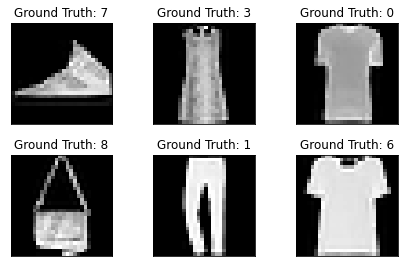

In [5]:
# draw the sample graph of Fashion-MNIST dataset
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(examples_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(examples_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
# construct our CNN model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Sample code for convolutional layers
        
        # Convolutional layer #1.
        # Input image size 28x28x1
        # Computes 8 features using a 5x5 filter with ReLU activation.
        # After max pooling layer with a 2x2 filter and stride of 2.
        # Output image size 12x12x8
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        # Convolutional layer #2.
        # Input image size 12x12x8
        # Computes 32 features using a 5x5 filter with ReLU activation.
        # After max pooling layer with a 2x2 filter and stride of 2.
        # Output image size 4x4x32
        self.conv2 = nn.Conv2d(8, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        
        # two full connected laryers
        self.fc1 = nn.Linear(4 * 4 * 32 , 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4 * 4 * 32)  # flatten the dimension
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)
    


In [7]:
# Initialize network and optimizer
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)
device = torch.device("cpu")

output_prob = []
losses = []
accuracies = []
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

In [8]:
#define the train function 
def train(epoch):
    network.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')
    return losses

In [9]:
# define the test function 

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            
            # extract the output of the model(softmax outpout)
            output_prob.append(output.tolist())
            
            test_loss += F.nll_loss(output, target,reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    loss_list.append(test_loss)
    accuracy_list.append(100. * correct / len(test_loader.dataset))  
    return (float(correct) / len(test_loader.dataset))
    

In [10]:
# start to train and test data for each epoch

for epoch in range(1, n_epochs+1):
    losses.extend(train(epoch))
    accuracies.append(test())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306867
Train Epoch: 1 [160/60000 (0%)]	Loss: 2.271981
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.298740
Train Epoch: 1 [480/60000 (1%)]	Loss: 2.370212
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298354
Train Epoch: 1 [800/60000 (1%)]	Loss: 2.274224
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.027263
Train Epoch: 1 [1120/60000 (2%)]	Loss: 1.900085
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.222523
Train Epoch: 1 [1440/60000 (2%)]	Loss: 1.892726
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.233783
Train Epoch: 1 [1760/60000 (3%)]	Loss: 1.395503
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.336112
Train Epoch: 1 [2080/60000 (3%)]	Loss: 1.417432
Train Epoch: 1 [2240/60000 (4%)]	Loss: 1.585194
Train Epoch: 1 [2400/60000 (4%)]	Loss: 1.431609
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.743304
Train Epoch: 1 [2720/60000 (5%)]	Loss: 1.317481
Train Epoch: 1 [2880/60000 (5%)]	Loss: 1.819701
Train Epoch: 1 [3040/60000 (5%)]	Loss: 1.742621
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.348713
T

Train Epoch: 1 [27200/60000 (45%)]	Loss: 0.498571
Train Epoch: 1 [27360/60000 (46%)]	Loss: 0.557485
Train Epoch: 1 [27520/60000 (46%)]	Loss: 0.714445
Train Epoch: 1 [27680/60000 (46%)]	Loss: 0.773102
Train Epoch: 1 [27840/60000 (46%)]	Loss: 0.390677
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.714693
Train Epoch: 1 [28160/60000 (47%)]	Loss: 1.062146
Train Epoch: 1 [28320/60000 (47%)]	Loss: 0.449443
Train Epoch: 1 [28480/60000 (47%)]	Loss: 1.250418
Train Epoch: 1 [28640/60000 (48%)]	Loss: 0.819171
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.559412
Train Epoch: 1 [28960/60000 (48%)]	Loss: 0.476507
Train Epoch: 1 [29120/60000 (49%)]	Loss: 0.755320
Train Epoch: 1 [29280/60000 (49%)]	Loss: 1.023673
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.369216
Train Epoch: 1 [29600/60000 (49%)]	Loss: 1.024727
Train Epoch: 1 [29760/60000 (50%)]	Loss: 0.320670
Train Epoch: 1 [29920/60000 (50%)]	Loss: 0.696555
Train Epoch: 1 [30080/60000 (50%)]	Loss: 0.637182
Train Epoch: 1 [30240/60000 (50%)]	Loss: 0.910640


Train Epoch: 1 [53600/60000 (89%)]	Loss: 1.106506
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.619476
Train Epoch: 1 [53920/60000 (90%)]	Loss: 0.609496
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.792662
Train Epoch: 1 [54240/60000 (90%)]	Loss: 0.388767
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.724854
Train Epoch: 1 [54560/60000 (91%)]	Loss: 0.471796
Train Epoch: 1 [54720/60000 (91%)]	Loss: 0.283513
Train Epoch: 1 [54880/60000 (91%)]	Loss: 0.994014
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.815753
Train Epoch: 1 [55200/60000 (92%)]	Loss: 0.158715
Train Epoch: 1 [55360/60000 (92%)]	Loss: 0.743731
Train Epoch: 1 [55520/60000 (93%)]	Loss: 0.702871
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.195972
Train Epoch: 1 [55840/60000 (93%)]	Loss: 0.493507
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.655089
Train Epoch: 1 [56160/60000 (94%)]	Loss: 0.353944
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.463891
Train Epoch: 1 [56480/60000 (94%)]	Loss: 0.810712
Train Epoch: 1 [56640/60000 (94%)]	Loss: 0.472943


Train Epoch: 2 [20160/60000 (34%)]	Loss: 0.385004
Train Epoch: 2 [20320/60000 (34%)]	Loss: 0.547116
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.873636
Train Epoch: 2 [20640/60000 (34%)]	Loss: 0.478163
Train Epoch: 2 [20800/60000 (35%)]	Loss: 0.592091
Train Epoch: 2 [20960/60000 (35%)]	Loss: 0.448851
Train Epoch: 2 [21120/60000 (35%)]	Loss: 0.320112
Train Epoch: 2 [21280/60000 (35%)]	Loss: 0.619570
Train Epoch: 2 [21440/60000 (36%)]	Loss: 0.591988
Train Epoch: 2 [21600/60000 (36%)]	Loss: 0.377219
Train Epoch: 2 [21760/60000 (36%)]	Loss: 0.184535
Train Epoch: 2 [21920/60000 (37%)]	Loss: 0.654466
Train Epoch: 2 [22080/60000 (37%)]	Loss: 0.917605
Train Epoch: 2 [22240/60000 (37%)]	Loss: 0.756087
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.391968
Train Epoch: 2 [22560/60000 (38%)]	Loss: 0.390224
Train Epoch: 2 [22720/60000 (38%)]	Loss: 0.542346
Train Epoch: 2 [22880/60000 (38%)]	Loss: 0.466427
Train Epoch: 2 [23040/60000 (38%)]	Loss: 0.593221
Train Epoch: 2 [23200/60000 (39%)]	Loss: 0.530438


Train Epoch: 2 [46560/60000 (78%)]	Loss: 0.410911
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.706647
Train Epoch: 2 [46880/60000 (78%)]	Loss: 0.718166
Train Epoch: 2 [47040/60000 (78%)]	Loss: 0.168412
Train Epoch: 2 [47200/60000 (79%)]	Loss: 0.702776
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.709638
Train Epoch: 2 [47520/60000 (79%)]	Loss: 0.444456
Train Epoch: 2 [47680/60000 (79%)]	Loss: 0.570196
Train Epoch: 2 [47840/60000 (80%)]	Loss: 0.376027
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.348515
Train Epoch: 2 [48160/60000 (80%)]	Loss: 0.404747
Train Epoch: 2 [48320/60000 (81%)]	Loss: 0.443564
Train Epoch: 2 [48480/60000 (81%)]	Loss: 0.310885
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.326013
Train Epoch: 2 [48800/60000 (81%)]	Loss: 0.726580
Train Epoch: 2 [48960/60000 (82%)]	Loss: 0.678978
Train Epoch: 2 [49120/60000 (82%)]	Loss: 0.662713
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.242030
Train Epoch: 2 [49440/60000 (82%)]	Loss: 0.789931
Train Epoch: 2 [49600/60000 (83%)]	Loss: 0.697154


Train Epoch: 3 [12960/60000 (22%)]	Loss: 0.693693
Train Epoch: 3 [13120/60000 (22%)]	Loss: 0.286413
Train Epoch: 3 [13280/60000 (22%)]	Loss: 0.414590
Train Epoch: 3 [13440/60000 (22%)]	Loss: 0.744634
Train Epoch: 3 [13600/60000 (23%)]	Loss: 1.161482
Train Epoch: 3 [13760/60000 (23%)]	Loss: 0.949831
Train Epoch: 3 [13920/60000 (23%)]	Loss: 0.396885
Train Epoch: 3 [14080/60000 (23%)]	Loss: 0.268888
Train Epoch: 3 [14240/60000 (24%)]	Loss: 0.531873
Train Epoch: 3 [14400/60000 (24%)]	Loss: 0.504882
Train Epoch: 3 [14560/60000 (24%)]	Loss: 0.360457
Train Epoch: 3 [14720/60000 (25%)]	Loss: 0.212249
Train Epoch: 3 [14880/60000 (25%)]	Loss: 0.133821
Train Epoch: 3 [15040/60000 (25%)]	Loss: 0.393897
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.433663
Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.480552
Train Epoch: 3 [15520/60000 (26%)]	Loss: 0.398371
Train Epoch: 3 [15680/60000 (26%)]	Loss: 0.912696
Train Epoch: 3 [15840/60000 (26%)]	Loss: 0.552949
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.662876


Train Epoch: 3 [39200/60000 (65%)]	Loss: 0.912458
Train Epoch: 3 [39360/60000 (66%)]	Loss: 0.740381
Train Epoch: 3 [39520/60000 (66%)]	Loss: 0.779083
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.241369
Train Epoch: 3 [39840/60000 (66%)]	Loss: 0.582064
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.299070
Train Epoch: 3 [40160/60000 (67%)]	Loss: 0.521532
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.808910
Train Epoch: 3 [40480/60000 (67%)]	Loss: 0.641537
Train Epoch: 3 [40640/60000 (68%)]	Loss: 0.316650
Train Epoch: 3 [40800/60000 (68%)]	Loss: 0.407807
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.190969
Train Epoch: 3 [41120/60000 (69%)]	Loss: 0.427642
Train Epoch: 3 [41280/60000 (69%)]	Loss: 0.327578
Train Epoch: 3 [41440/60000 (69%)]	Loss: 0.224565
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.565557
Train Epoch: 3 [41760/60000 (70%)]	Loss: 0.594074
Train Epoch: 3 [41920/60000 (70%)]	Loss: 0.317658
Train Epoch: 3 [42080/60000 (70%)]	Loss: 0.821585
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.653316


Train Epoch: 4 [6080/60000 (10%)]	Loss: 0.573032
Train Epoch: 4 [6240/60000 (10%)]	Loss: 0.154003
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.402814
Train Epoch: 4 [6560/60000 (11%)]	Loss: 0.325071
Train Epoch: 4 [6720/60000 (11%)]	Loss: 0.440439
Train Epoch: 4 [6880/60000 (11%)]	Loss: 0.564460
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.626475
Train Epoch: 4 [7200/60000 (12%)]	Loss: 0.515465
Train Epoch: 4 [7360/60000 (12%)]	Loss: 0.587947
Train Epoch: 4 [7520/60000 (13%)]	Loss: 0.396435
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.348286
Train Epoch: 4 [7840/60000 (13%)]	Loss: 0.264302
Train Epoch: 4 [8000/60000 (13%)]	Loss: 0.149130
Train Epoch: 4 [8160/60000 (14%)]	Loss: 0.911654
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.800777
Train Epoch: 4 [8480/60000 (14%)]	Loss: 0.144402
Train Epoch: 4 [8640/60000 (14%)]	Loss: 0.842253
Train Epoch: 4 [8800/60000 (15%)]	Loss: 0.626855
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.481284
Train Epoch: 4 [9120/60000 (15%)]	Loss: 0.551701
Train Epoch: 4 [9280

Train Epoch: 4 [32800/60000 (55%)]	Loss: 0.357763
Train Epoch: 4 [32960/60000 (55%)]	Loss: 0.050726
Train Epoch: 4 [33120/60000 (55%)]	Loss: 0.662892
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.587237
Train Epoch: 4 [33440/60000 (56%)]	Loss: 0.686620
Train Epoch: 4 [33600/60000 (56%)]	Loss: 0.431223
Train Epoch: 4 [33760/60000 (56%)]	Loss: 0.528766
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.617456
Train Epoch: 4 [34080/60000 (57%)]	Loss: 0.467985
Train Epoch: 4 [34240/60000 (57%)]	Loss: 0.714834
Train Epoch: 4 [34400/60000 (57%)]	Loss: 0.533291
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.318683
Train Epoch: 4 [34720/60000 (58%)]	Loss: 0.145497
Train Epoch: 4 [34880/60000 (58%)]	Loss: 0.511545
Train Epoch: 4 [35040/60000 (58%)]	Loss: 0.941721
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.539212
Train Epoch: 4 [35360/60000 (59%)]	Loss: 0.389608
Train Epoch: 4 [35520/60000 (59%)]	Loss: 0.465921
Train Epoch: 4 [35680/60000 (59%)]	Loss: 0.457875
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.452914


Train Epoch: 4 [59200/60000 (99%)]	Loss: 0.309665
Train Epoch: 4 [59360/60000 (99%)]	Loss: 0.405894
Train Epoch: 4 [59520/60000 (99%)]	Loss: 0.517317
Train Epoch: 4 [59680/60000 (99%)]	Loss: 0.527152
Train Epoch: 4 [59840/60000 (100%)]	Loss: 0.867130

Test set: Avg. loss: 0.4206, Accuracy: 8366/10000 (83.66%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.410408
Train Epoch: 5 [160/60000 (0%)]	Loss: 0.418496
Train Epoch: 5 [320/60000 (1%)]	Loss: 0.352824
Train Epoch: 5 [480/60000 (1%)]	Loss: 0.173352
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.279294
Train Epoch: 5 [800/60000 (1%)]	Loss: 0.341201
Train Epoch: 5 [960/60000 (2%)]	Loss: 0.329309
Train Epoch: 5 [1120/60000 (2%)]	Loss: 0.181563
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.343549
Train Epoch: 5 [1440/60000 (2%)]	Loss: 0.396779
Train Epoch: 5 [1600/60000 (3%)]	Loss: 0.319947
Train Epoch: 5 [1760/60000 (3%)]	Loss: 0.233350
Train Epoch: 5 [1920/60000 (3%)]	Loss: 1.237927
Train Epoch: 5 [2080/60000 (3%)]	Loss: 0.651798
Train Epoch: 5 [2240/6000

Train Epoch: 5 [25920/60000 (43%)]	Loss: 0.388131
Train Epoch: 5 [26080/60000 (43%)]	Loss: 0.618903
Train Epoch: 5 [26240/60000 (44%)]	Loss: 1.093670
Train Epoch: 5 [26400/60000 (44%)]	Loss: 0.578052
Train Epoch: 5 [26560/60000 (44%)]	Loss: 0.504470
Train Epoch: 5 [26720/60000 (45%)]	Loss: 0.729639
Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.524187
Train Epoch: 5 [27040/60000 (45%)]	Loss: 0.768085
Train Epoch: 5 [27200/60000 (45%)]	Loss: 0.423995
Train Epoch: 5 [27360/60000 (46%)]	Loss: 0.389158
Train Epoch: 5 [27520/60000 (46%)]	Loss: 0.983787
Train Epoch: 5 [27680/60000 (46%)]	Loss: 0.310462
Train Epoch: 5 [27840/60000 (46%)]	Loss: 0.465844
Train Epoch: 5 [28000/60000 (47%)]	Loss: 0.248397
Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.626889
Train Epoch: 5 [28320/60000 (47%)]	Loss: 0.284952
Train Epoch: 5 [28480/60000 (47%)]	Loss: 1.280843
Train Epoch: 5 [28640/60000 (48%)]	Loss: 0.886313
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.420779
Train Epoch: 5 [28960/60000 (48%)]	Loss: 0.425394


Train Epoch: 5 [52320/60000 (87%)]	Loss: 0.296263
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.119435
Train Epoch: 5 [52640/60000 (88%)]	Loss: 0.481265
Train Epoch: 5 [52800/60000 (88%)]	Loss: 0.404587
Train Epoch: 5 [52960/60000 (88%)]	Loss: 0.594597
Train Epoch: 5 [53120/60000 (89%)]	Loss: 0.548428
Train Epoch: 5 [53280/60000 (89%)]	Loss: 0.423507
Train Epoch: 5 [53440/60000 (89%)]	Loss: 0.261570
Train Epoch: 5 [53600/60000 (89%)]	Loss: 0.338359
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.458545
Train Epoch: 5 [53920/60000 (90%)]	Loss: 0.450662
Train Epoch: 5 [54080/60000 (90%)]	Loss: 0.417590
Train Epoch: 5 [54240/60000 (90%)]	Loss: 0.729758
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.413006
Train Epoch: 5 [54560/60000 (91%)]	Loss: 0.770145
Train Epoch: 5 [54720/60000 (91%)]	Loss: 0.817780
Train Epoch: 5 [54880/60000 (91%)]	Loss: 1.297979
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.542553
Train Epoch: 5 [55200/60000 (92%)]	Loss: 0.281889
Train Epoch: 5 [55360/60000 (92%)]	Loss: 0.138528


Train Epoch: 6 [19040/60000 (32%)]	Loss: 0.585344
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.164201
Train Epoch: 6 [19360/60000 (32%)]	Loss: 0.585681
Train Epoch: 6 [19520/60000 (33%)]	Loss: 0.828549
Train Epoch: 6 [19680/60000 (33%)]	Loss: 0.975799
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.636105
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.498468
Train Epoch: 6 [20160/60000 (34%)]	Loss: 0.656774
Train Epoch: 6 [20320/60000 (34%)]	Loss: 0.543313
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.572344
Train Epoch: 6 [20640/60000 (34%)]	Loss: 0.250498
Train Epoch: 6 [20800/60000 (35%)]	Loss: 0.327314
Train Epoch: 6 [20960/60000 (35%)]	Loss: 0.504559
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.368729
Train Epoch: 6 [21280/60000 (35%)]	Loss: 0.478375
Train Epoch: 6 [21440/60000 (36%)]	Loss: 0.549106
Train Epoch: 6 [21600/60000 (36%)]	Loss: 0.275917
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.393909
Train Epoch: 6 [21920/60000 (37%)]	Loss: 0.463649
Train Epoch: 6 [22080/60000 (37%)]	Loss: 0.643116


Train Epoch: 6 [45760/60000 (76%)]	Loss: 0.461282
Train Epoch: 6 [45920/60000 (77%)]	Loss: 0.215482
Train Epoch: 6 [46080/60000 (77%)]	Loss: 0.563270
Train Epoch: 6 [46240/60000 (77%)]	Loss: 0.904497
Train Epoch: 6 [46400/60000 (77%)]	Loss: 1.526285
Train Epoch: 6 [46560/60000 (78%)]	Loss: 0.293362
Train Epoch: 6 [46720/60000 (78%)]	Loss: 0.482247
Train Epoch: 6 [46880/60000 (78%)]	Loss: 0.347281
Train Epoch: 6 [47040/60000 (78%)]	Loss: 0.301329
Train Epoch: 6 [47200/60000 (79%)]	Loss: 0.176094
Train Epoch: 6 [47360/60000 (79%)]	Loss: 0.233126
Train Epoch: 6 [47520/60000 (79%)]	Loss: 0.476688
Train Epoch: 6 [47680/60000 (79%)]	Loss: 0.554919
Train Epoch: 6 [47840/60000 (80%)]	Loss: 0.571120
Train Epoch: 6 [48000/60000 (80%)]	Loss: 0.403611
Train Epoch: 6 [48160/60000 (80%)]	Loss: 0.537739
Train Epoch: 6 [48320/60000 (81%)]	Loss: 0.317141
Train Epoch: 6 [48480/60000 (81%)]	Loss: 0.823184
Train Epoch: 6 [48640/60000 (81%)]	Loss: 0.530371
Train Epoch: 6 [48800/60000 (81%)]	Loss: 0.304866


Train Epoch: 7 [12320/60000 (21%)]	Loss: 0.312669
Train Epoch: 7 [12480/60000 (21%)]	Loss: 0.226557
Train Epoch: 7 [12640/60000 (21%)]	Loss: 0.311269
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.355371
Train Epoch: 7 [12960/60000 (22%)]	Loss: 0.192007
Train Epoch: 7 [13120/60000 (22%)]	Loss: 0.259188
Train Epoch: 7 [13280/60000 (22%)]	Loss: 0.781543
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.174871
Train Epoch: 7 [13600/60000 (23%)]	Loss: 0.996767
Train Epoch: 7 [13760/60000 (23%)]	Loss: 0.673391
Train Epoch: 7 [13920/60000 (23%)]	Loss: 0.356105
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.321727
Train Epoch: 7 [14240/60000 (24%)]	Loss: 0.766268
Train Epoch: 7 [14400/60000 (24%)]	Loss: 0.258938
Train Epoch: 7 [14560/60000 (24%)]	Loss: 0.513393
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.602427
Train Epoch: 7 [14880/60000 (25%)]	Loss: 0.643717
Train Epoch: 7 [15040/60000 (25%)]	Loss: 0.251617
Train Epoch: 7 [15200/60000 (25%)]	Loss: 0.074211
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.304910


Train Epoch: 7 [39040/60000 (65%)]	Loss: 0.156857
Train Epoch: 7 [39200/60000 (65%)]	Loss: 0.533387
Train Epoch: 7 [39360/60000 (66%)]	Loss: 0.757673
Train Epoch: 7 [39520/60000 (66%)]	Loss: 0.574806
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.499278
Train Epoch: 7 [39840/60000 (66%)]	Loss: 0.360811
Train Epoch: 7 [40000/60000 (67%)]	Loss: 0.409775
Train Epoch: 7 [40160/60000 (67%)]	Loss: 0.301944
Train Epoch: 7 [40320/60000 (67%)]	Loss: 0.528957
Train Epoch: 7 [40480/60000 (67%)]	Loss: 0.496943
Train Epoch: 7 [40640/60000 (68%)]	Loss: 0.757463
Train Epoch: 7 [40800/60000 (68%)]	Loss: 1.056806
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.436944
Train Epoch: 7 [41120/60000 (69%)]	Loss: 0.440704
Train Epoch: 7 [41280/60000 (69%)]	Loss: 0.358873
Train Epoch: 7 [41440/60000 (69%)]	Loss: 0.979581
Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.449608
Train Epoch: 7 [41760/60000 (70%)]	Loss: 0.428780
Train Epoch: 7 [41920/60000 (70%)]	Loss: 0.155338
Train Epoch: 7 [42080/60000 (70%)]	Loss: 0.577472


Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.408587
Train Epoch: 8 [5920/60000 (10%)]	Loss: 0.178557
Train Epoch: 8 [6080/60000 (10%)]	Loss: 0.675942
Train Epoch: 8 [6240/60000 (10%)]	Loss: 0.548052
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.734968
Train Epoch: 8 [6560/60000 (11%)]	Loss: 0.347877
Train Epoch: 8 [6720/60000 (11%)]	Loss: 0.656175
Train Epoch: 8 [6880/60000 (11%)]	Loss: 0.248029
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.532728
Train Epoch: 8 [7200/60000 (12%)]	Loss: 0.235475
Train Epoch: 8 [7360/60000 (12%)]	Loss: 0.461032
Train Epoch: 8 [7520/60000 (13%)]	Loss: 0.715807
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.329828
Train Epoch: 8 [7840/60000 (13%)]	Loss: 0.319722
Train Epoch: 8 [8000/60000 (13%)]	Loss: 0.416822
Train Epoch: 8 [8160/60000 (14%)]	Loss: 0.386656
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.307020
Train Epoch: 8 [8480/60000 (14%)]	Loss: 0.569728
Train Epoch: 8 [8640/60000 (14%)]	Loss: 0.378518
Train Epoch: 8 [8800/60000 (15%)]	Loss: 0.242947
Train Epoch: 8 [8960

Train Epoch: 8 [32640/60000 (54%)]	Loss: 0.420668
Train Epoch: 8 [32800/60000 (55%)]	Loss: 0.460472
Train Epoch: 8 [32960/60000 (55%)]	Loss: 0.422985
Train Epoch: 8 [33120/60000 (55%)]	Loss: 0.336123
Train Epoch: 8 [33280/60000 (55%)]	Loss: 0.469774
Train Epoch: 8 [33440/60000 (56%)]	Loss: 0.150680
Train Epoch: 8 [33600/60000 (56%)]	Loss: 0.502839
Train Epoch: 8 [33760/60000 (56%)]	Loss: 0.255166
Train Epoch: 8 [33920/60000 (57%)]	Loss: 0.546044
Train Epoch: 8 [34080/60000 (57%)]	Loss: 0.285871
Train Epoch: 8 [34240/60000 (57%)]	Loss: 0.217351
Train Epoch: 8 [34400/60000 (57%)]	Loss: 0.669027
Train Epoch: 8 [34560/60000 (58%)]	Loss: 0.797752
Train Epoch: 8 [34720/60000 (58%)]	Loss: 0.246718
Train Epoch: 8 [34880/60000 (58%)]	Loss: 0.538170
Train Epoch: 8 [35040/60000 (58%)]	Loss: 0.579145
Train Epoch: 8 [35200/60000 (59%)]	Loss: 0.179366
Train Epoch: 8 [35360/60000 (59%)]	Loss: 0.710061
Train Epoch: 8 [35520/60000 (59%)]	Loss: 0.316529
Train Epoch: 8 [35680/60000 (59%)]	Loss: 0.856368


Train Epoch: 8 [59360/60000 (99%)]	Loss: 0.719071
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.223646
Train Epoch: 8 [59680/60000 (99%)]	Loss: 0.472662
Train Epoch: 8 [59840/60000 (100%)]	Loss: 0.647467

Test set: Avg. loss: 0.3711, Accuracy: 8553/10000 (85.53%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.726684
Train Epoch: 9 [160/60000 (0%)]	Loss: 0.629910
Train Epoch: 9 [320/60000 (1%)]	Loss: 0.562215
Train Epoch: 9 [480/60000 (1%)]	Loss: 0.466635
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.702993
Train Epoch: 9 [800/60000 (1%)]	Loss: 0.232119
Train Epoch: 9 [960/60000 (2%)]	Loss: 0.143205
Train Epoch: 9 [1120/60000 (2%)]	Loss: 0.746767
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.211665
Train Epoch: 9 [1440/60000 (2%)]	Loss: 0.885881
Train Epoch: 9 [1600/60000 (3%)]	Loss: 0.823286
Train Epoch: 9 [1760/60000 (3%)]	Loss: 0.371092
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.353673
Train Epoch: 9 [2080/60000 (3%)]	Loss: 0.229735
Train Epoch: 9 [2240/60000 (4%)]	Loss: 0.633499
Train Epoch: 9 [2400/60000 

Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.633385
Train Epoch: 9 [26400/60000 (44%)]	Loss: 0.325751
Train Epoch: 9 [26560/60000 (44%)]	Loss: 0.454533
Train Epoch: 9 [26720/60000 (45%)]	Loss: 0.836478
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.323680
Train Epoch: 9 [27040/60000 (45%)]	Loss: 0.826695
Train Epoch: 9 [27200/60000 (45%)]	Loss: 0.314263
Train Epoch: 9 [27360/60000 (46%)]	Loss: 1.343243
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.161877
Train Epoch: 9 [27680/60000 (46%)]	Loss: 0.244007
Train Epoch: 9 [27840/60000 (46%)]	Loss: 0.286568
Train Epoch: 9 [28000/60000 (47%)]	Loss: 0.419528
Train Epoch: 9 [28160/60000 (47%)]	Loss: 0.065271
Train Epoch: 9 [28320/60000 (47%)]	Loss: 0.496426
Train Epoch: 9 [28480/60000 (47%)]	Loss: 0.367188
Train Epoch: 9 [28640/60000 (48%)]	Loss: 0.383309
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.314197
Train Epoch: 9 [28960/60000 (48%)]	Loss: 1.058418
Train Epoch: 9 [29120/60000 (49%)]	Loss: 0.313857
Train Epoch: 9 [29280/60000 (49%)]	Loss: 0.301172


Train Epoch: 9 [52640/60000 (88%)]	Loss: 0.153879
Train Epoch: 9 [52800/60000 (88%)]	Loss: 0.356114
Train Epoch: 9 [52960/60000 (88%)]	Loss: 0.340927
Train Epoch: 9 [53120/60000 (89%)]	Loss: 0.163288
Train Epoch: 9 [53280/60000 (89%)]	Loss: 0.372879
Train Epoch: 9 [53440/60000 (89%)]	Loss: 0.560791
Train Epoch: 9 [53600/60000 (89%)]	Loss: 0.917491
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.306469
Train Epoch: 9 [53920/60000 (90%)]	Loss: 0.528444
Train Epoch: 9 [54080/60000 (90%)]	Loss: 0.526615
Train Epoch: 9 [54240/60000 (90%)]	Loss: 0.351451
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.604653
Train Epoch: 9 [54560/60000 (91%)]	Loss: 0.158692
Train Epoch: 9 [54720/60000 (91%)]	Loss: 0.905782
Train Epoch: 9 [54880/60000 (91%)]	Loss: 0.493088
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.199617
Train Epoch: 9 [55200/60000 (92%)]	Loss: 0.791514
Train Epoch: 9 [55360/60000 (92%)]	Loss: 0.102527
Train Epoch: 9 [55520/60000 (93%)]	Loss: 0.304457
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.387058


Train Epoch: 10 [19360/60000 (32%)]	Loss: 0.154080
Train Epoch: 10 [19520/60000 (33%)]	Loss: 0.236359
Train Epoch: 10 [19680/60000 (33%)]	Loss: 0.475492
Train Epoch: 10 [19840/60000 (33%)]	Loss: 0.272965
Train Epoch: 10 [20000/60000 (33%)]	Loss: 0.439757
Train Epoch: 10 [20160/60000 (34%)]	Loss: 0.471185
Train Epoch: 10 [20320/60000 (34%)]	Loss: 0.257550
Train Epoch: 10 [20480/60000 (34%)]	Loss: 0.773184
Train Epoch: 10 [20640/60000 (34%)]	Loss: 0.525433
Train Epoch: 10 [20800/60000 (35%)]	Loss: 0.486887
Train Epoch: 10 [20960/60000 (35%)]	Loss: 0.313176
Train Epoch: 10 [21120/60000 (35%)]	Loss: 0.604859
Train Epoch: 10 [21280/60000 (35%)]	Loss: 0.707061
Train Epoch: 10 [21440/60000 (36%)]	Loss: 0.230411
Train Epoch: 10 [21600/60000 (36%)]	Loss: 0.570893
Train Epoch: 10 [21760/60000 (36%)]	Loss: 0.540916
Train Epoch: 10 [21920/60000 (37%)]	Loss: 0.221282
Train Epoch: 10 [22080/60000 (37%)]	Loss: 0.623858
Train Epoch: 10 [22240/60000 (37%)]	Loss: 0.162124
Train Epoch: 10 [22400/60000 (3

Train Epoch: 10 [45760/60000 (76%)]	Loss: 0.124435
Train Epoch: 10 [45920/60000 (77%)]	Loss: 0.613113
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.299138
Train Epoch: 10 [46240/60000 (77%)]	Loss: 0.295455
Train Epoch: 10 [46400/60000 (77%)]	Loss: 0.406617
Train Epoch: 10 [46560/60000 (78%)]	Loss: 0.262576
Train Epoch: 10 [46720/60000 (78%)]	Loss: 0.390439
Train Epoch: 10 [46880/60000 (78%)]	Loss: 0.122458
Train Epoch: 10 [47040/60000 (78%)]	Loss: 0.418902
Train Epoch: 10 [47200/60000 (79%)]	Loss: 0.292222
Train Epoch: 10 [47360/60000 (79%)]	Loss: 0.244710
Train Epoch: 10 [47520/60000 (79%)]	Loss: 0.361407
Train Epoch: 10 [47680/60000 (79%)]	Loss: 0.350570
Train Epoch: 10 [47840/60000 (80%)]	Loss: 0.316790
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.792581
Train Epoch: 10 [48160/60000 (80%)]	Loss: 0.187844
Train Epoch: 10 [48320/60000 (81%)]	Loss: 0.243514
Train Epoch: 10 [48480/60000 (81%)]	Loss: 0.335590
Train Epoch: 10 [48640/60000 (81%)]	Loss: 0.444293
Train Epoch: 10 [48800/60000 (8

Train Epoch: 11 [11840/60000 (20%)]	Loss: 0.431280
Train Epoch: 11 [12000/60000 (20%)]	Loss: 0.403616
Train Epoch: 11 [12160/60000 (20%)]	Loss: 1.455189
Train Epoch: 11 [12320/60000 (21%)]	Loss: 0.364643
Train Epoch: 11 [12480/60000 (21%)]	Loss: 0.569867
Train Epoch: 11 [12640/60000 (21%)]	Loss: 0.608366
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.137700
Train Epoch: 11 [12960/60000 (22%)]	Loss: 0.580929
Train Epoch: 11 [13120/60000 (22%)]	Loss: 0.314204
Train Epoch: 11 [13280/60000 (22%)]	Loss: 0.149457
Train Epoch: 11 [13440/60000 (22%)]	Loss: 0.390751
Train Epoch: 11 [13600/60000 (23%)]	Loss: 1.010250
Train Epoch: 11 [13760/60000 (23%)]	Loss: 0.709287
Train Epoch: 11 [13920/60000 (23%)]	Loss: 0.720985
Train Epoch: 11 [14080/60000 (23%)]	Loss: 0.597016
Train Epoch: 11 [14240/60000 (24%)]	Loss: 0.274659
Train Epoch: 11 [14400/60000 (24%)]	Loss: 0.307343
Train Epoch: 11 [14560/60000 (24%)]	Loss: 0.429544
Train Epoch: 11 [14720/60000 (25%)]	Loss: 0.616584
Train Epoch: 11 [14880/60000 (2

Train Epoch: 11 [37920/60000 (63%)]	Loss: 0.280638
Train Epoch: 11 [38080/60000 (63%)]	Loss: 0.769128
Train Epoch: 11 [38240/60000 (64%)]	Loss: 1.175720
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.467609
Train Epoch: 11 [38560/60000 (64%)]	Loss: 0.437249
Train Epoch: 11 [38720/60000 (65%)]	Loss: 0.233520
Train Epoch: 11 [38880/60000 (65%)]	Loss: 0.788509
Train Epoch: 11 [39040/60000 (65%)]	Loss: 0.133170
Train Epoch: 11 [39200/60000 (65%)]	Loss: 0.446524
Train Epoch: 11 [39360/60000 (66%)]	Loss: 0.185619
Train Epoch: 11 [39520/60000 (66%)]	Loss: 0.557689
Train Epoch: 11 [39680/60000 (66%)]	Loss: 0.352801
Train Epoch: 11 [39840/60000 (66%)]	Loss: 0.364176
Train Epoch: 11 [40000/60000 (67%)]	Loss: 0.429287
Train Epoch: 11 [40160/60000 (67%)]	Loss: 0.752270
Train Epoch: 11 [40320/60000 (67%)]	Loss: 0.529236
Train Epoch: 11 [40480/60000 (67%)]	Loss: 0.582815
Train Epoch: 11 [40640/60000 (68%)]	Loss: 0.633633
Train Epoch: 11 [40800/60000 (68%)]	Loss: 0.410986
Train Epoch: 11 [40960/60000 (6

Train Epoch: 12 [4160/60000 (7%)]	Loss: 0.223581
Train Epoch: 12 [4320/60000 (7%)]	Loss: 0.686027
Train Epoch: 12 [4480/60000 (7%)]	Loss: 0.163229
Train Epoch: 12 [4640/60000 (8%)]	Loss: 0.506359
Train Epoch: 12 [4800/60000 (8%)]	Loss: 0.343789
Train Epoch: 12 [4960/60000 (8%)]	Loss: 0.430604
Train Epoch: 12 [5120/60000 (9%)]	Loss: 0.295178
Train Epoch: 12 [5280/60000 (9%)]	Loss: 0.586080
Train Epoch: 12 [5440/60000 (9%)]	Loss: 0.418317
Train Epoch: 12 [5600/60000 (9%)]	Loss: 0.137826
Train Epoch: 12 [5760/60000 (10%)]	Loss: 0.333958
Train Epoch: 12 [5920/60000 (10%)]	Loss: 0.637995
Train Epoch: 12 [6080/60000 (10%)]	Loss: 0.210831
Train Epoch: 12 [6240/60000 (10%)]	Loss: 0.294377
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.308355
Train Epoch: 12 [6560/60000 (11%)]	Loss: 0.323711
Train Epoch: 12 [6720/60000 (11%)]	Loss: 0.214923
Train Epoch: 12 [6880/60000 (11%)]	Loss: 0.240220
Train Epoch: 12 [7040/60000 (12%)]	Loss: 0.190306
Train Epoch: 12 [7200/60000 (12%)]	Loss: 0.526054
Train Epoc

Train Epoch: 12 [30400/60000 (51%)]	Loss: 0.381380
Train Epoch: 12 [30560/60000 (51%)]	Loss: 0.804375
Train Epoch: 12 [30720/60000 (51%)]	Loss: 0.640846
Train Epoch: 12 [30880/60000 (51%)]	Loss: 0.101635
Train Epoch: 12 [31040/60000 (52%)]	Loss: 0.264065
Train Epoch: 12 [31200/60000 (52%)]	Loss: 0.857185
Train Epoch: 12 [31360/60000 (52%)]	Loss: 0.533429
Train Epoch: 12 [31520/60000 (53%)]	Loss: 0.286838
Train Epoch: 12 [31680/60000 (53%)]	Loss: 0.506361
Train Epoch: 12 [31840/60000 (53%)]	Loss: 0.305152
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.398019
Train Epoch: 12 [32160/60000 (54%)]	Loss: 0.134095
Train Epoch: 12 [32320/60000 (54%)]	Loss: 0.363485
Train Epoch: 12 [32480/60000 (54%)]	Loss: 0.394412
Train Epoch: 12 [32640/60000 (54%)]	Loss: 0.626749
Train Epoch: 12 [32800/60000 (55%)]	Loss: 0.547980
Train Epoch: 12 [32960/60000 (55%)]	Loss: 0.660692
Train Epoch: 12 [33120/60000 (55%)]	Loss: 0.265798
Train Epoch: 12 [33280/60000 (55%)]	Loss: 0.297851
Train Epoch: 12 [33440/60000 (5

Train Epoch: 12 [56320/60000 (94%)]	Loss: 0.232101
Train Epoch: 12 [56480/60000 (94%)]	Loss: 0.657827
Train Epoch: 12 [56640/60000 (94%)]	Loss: 0.338651
Train Epoch: 12 [56800/60000 (95%)]	Loss: 0.241375
Train Epoch: 12 [56960/60000 (95%)]	Loss: 0.512363
Train Epoch: 12 [57120/60000 (95%)]	Loss: 0.263485
Train Epoch: 12 [57280/60000 (95%)]	Loss: 0.398215
Train Epoch: 12 [57440/60000 (96%)]	Loss: 0.492673
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.379936
Train Epoch: 12 [57760/60000 (96%)]	Loss: 0.449901
Train Epoch: 12 [57920/60000 (97%)]	Loss: 0.413830
Train Epoch: 12 [58080/60000 (97%)]	Loss: 0.384475
Train Epoch: 12 [58240/60000 (97%)]	Loss: 0.404676
Train Epoch: 12 [58400/60000 (97%)]	Loss: 0.587303
Train Epoch: 12 [58560/60000 (98%)]	Loss: 0.344993
Train Epoch: 12 [58720/60000 (98%)]	Loss: 0.150930
Train Epoch: 12 [58880/60000 (98%)]	Loss: 0.254930
Train Epoch: 12 [59040/60000 (98%)]	Loss: 0.436295
Train Epoch: 12 [59200/60000 (99%)]	Loss: 0.273598
Train Epoch: 12 [59360/60000 (9

Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.639722
Train Epoch: 13 [22560/60000 (38%)]	Loss: 0.848265
Train Epoch: 13 [22720/60000 (38%)]	Loss: 0.387630
Train Epoch: 13 [22880/60000 (38%)]	Loss: 0.279190
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.251618
Train Epoch: 13 [23200/60000 (39%)]	Loss: 0.576200
Train Epoch: 13 [23360/60000 (39%)]	Loss: 0.291315
Train Epoch: 13 [23520/60000 (39%)]	Loss: 0.192583
Train Epoch: 13 [23680/60000 (39%)]	Loss: 0.369680
Train Epoch: 13 [23840/60000 (40%)]	Loss: 0.292648
Train Epoch: 13 [24000/60000 (40%)]	Loss: 0.220549
Train Epoch: 13 [24160/60000 (40%)]	Loss: 0.715176
Train Epoch: 13 [24320/60000 (41%)]	Loss: 0.336435
Train Epoch: 13 [24480/60000 (41%)]	Loss: 0.567637
Train Epoch: 13 [24640/60000 (41%)]	Loss: 0.250224
Train Epoch: 13 [24800/60000 (41%)]	Loss: 0.394890
Train Epoch: 13 [24960/60000 (42%)]	Loss: 0.562720
Train Epoch: 13 [25120/60000 (42%)]	Loss: 1.923916
Train Epoch: 13 [25280/60000 (42%)]	Loss: 0.322308
Train Epoch: 13 [25440/60000 (4

Train Epoch: 13 [48320/60000 (81%)]	Loss: 0.234900
Train Epoch: 13 [48480/60000 (81%)]	Loss: 0.393147
Train Epoch: 13 [48640/60000 (81%)]	Loss: 0.191421
Train Epoch: 13 [48800/60000 (81%)]	Loss: 0.583272
Train Epoch: 13 [48960/60000 (82%)]	Loss: 0.357986
Train Epoch: 13 [49120/60000 (82%)]	Loss: 0.536675
Train Epoch: 13 [49280/60000 (82%)]	Loss: 0.526885
Train Epoch: 13 [49440/60000 (82%)]	Loss: 0.511932
Train Epoch: 13 [49600/60000 (83%)]	Loss: 0.499797
Train Epoch: 13 [49760/60000 (83%)]	Loss: 0.529891
Train Epoch: 13 [49920/60000 (83%)]	Loss: 1.019498
Train Epoch: 13 [50080/60000 (83%)]	Loss: 0.244843
Train Epoch: 13 [50240/60000 (84%)]	Loss: 0.697303
Train Epoch: 13 [50400/60000 (84%)]	Loss: 0.644801
Train Epoch: 13 [50560/60000 (84%)]	Loss: 0.617668
Train Epoch: 13 [50720/60000 (85%)]	Loss: 0.330098
Train Epoch: 13 [50880/60000 (85%)]	Loss: 0.532593
Train Epoch: 13 [51040/60000 (85%)]	Loss: 0.472767
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.797348
Train Epoch: 13 [51360/60000 (8

Train Epoch: 14 [14240/60000 (24%)]	Loss: 0.172391
Train Epoch: 14 [14400/60000 (24%)]	Loss: 0.415425
Train Epoch: 14 [14560/60000 (24%)]	Loss: 0.126783
Train Epoch: 14 [14720/60000 (25%)]	Loss: 0.685383
Train Epoch: 14 [14880/60000 (25%)]	Loss: 0.220595
Train Epoch: 14 [15040/60000 (25%)]	Loss: 0.482496
Train Epoch: 14 [15200/60000 (25%)]	Loss: 0.283396
Train Epoch: 14 [15360/60000 (26%)]	Loss: 0.356805
Train Epoch: 14 [15520/60000 (26%)]	Loss: 0.383845
Train Epoch: 14 [15680/60000 (26%)]	Loss: 0.873225
Train Epoch: 14 [15840/60000 (26%)]	Loss: 0.577659
Train Epoch: 14 [16000/60000 (27%)]	Loss: 0.867989
Train Epoch: 14 [16160/60000 (27%)]	Loss: 0.624324
Train Epoch: 14 [16320/60000 (27%)]	Loss: 0.797597
Train Epoch: 14 [16480/60000 (27%)]	Loss: 0.485889
Train Epoch: 14 [16640/60000 (28%)]	Loss: 0.695392
Train Epoch: 14 [16800/60000 (28%)]	Loss: 0.312141
Train Epoch: 14 [16960/60000 (28%)]	Loss: 0.255462
Train Epoch: 14 [17120/60000 (29%)]	Loss: 0.130802
Train Epoch: 14 [17280/60000 (2

Train Epoch: 14 [40480/60000 (67%)]	Loss: 0.868596
Train Epoch: 14 [40640/60000 (68%)]	Loss: 0.727199
Train Epoch: 14 [40800/60000 (68%)]	Loss: 0.486258
Train Epoch: 14 [40960/60000 (68%)]	Loss: 0.319671
Train Epoch: 14 [41120/60000 (69%)]	Loss: 0.215852
Train Epoch: 14 [41280/60000 (69%)]	Loss: 0.454578
Train Epoch: 14 [41440/60000 (69%)]	Loss: 0.590083
Train Epoch: 14 [41600/60000 (69%)]	Loss: 0.206601
Train Epoch: 14 [41760/60000 (70%)]	Loss: 0.583823
Train Epoch: 14 [41920/60000 (70%)]	Loss: 0.486363
Train Epoch: 14 [42080/60000 (70%)]	Loss: 0.538677
Train Epoch: 14 [42240/60000 (70%)]	Loss: 0.726226
Train Epoch: 14 [42400/60000 (71%)]	Loss: 0.520225
Train Epoch: 14 [42560/60000 (71%)]	Loss: 0.574001
Train Epoch: 14 [42720/60000 (71%)]	Loss: 0.872405
Train Epoch: 14 [42880/60000 (71%)]	Loss: 0.496089
Train Epoch: 14 [43040/60000 (72%)]	Loss: 0.523442
Train Epoch: 14 [43200/60000 (72%)]	Loss: 0.310603
Train Epoch: 14 [43360/60000 (72%)]	Loss: 0.538871
Train Epoch: 14 [43520/60000 (7

Train Epoch: 15 [6880/60000 (11%)]	Loss: 0.695024
Train Epoch: 15 [7040/60000 (12%)]	Loss: 0.178167
Train Epoch: 15 [7200/60000 (12%)]	Loss: 0.190485
Train Epoch: 15 [7360/60000 (12%)]	Loss: 0.278978
Train Epoch: 15 [7520/60000 (13%)]	Loss: 0.479707
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.273164
Train Epoch: 15 [7840/60000 (13%)]	Loss: 0.976873
Train Epoch: 15 [8000/60000 (13%)]	Loss: 0.321854
Train Epoch: 15 [8160/60000 (14%)]	Loss: 0.191651
Train Epoch: 15 [8320/60000 (14%)]	Loss: 0.376193
Train Epoch: 15 [8480/60000 (14%)]	Loss: 0.513021
Train Epoch: 15 [8640/60000 (14%)]	Loss: 0.450628
Train Epoch: 15 [8800/60000 (15%)]	Loss: 0.548583
Train Epoch: 15 [8960/60000 (15%)]	Loss: 0.575245
Train Epoch: 15 [9120/60000 (15%)]	Loss: 0.936813
Train Epoch: 15 [9280/60000 (15%)]	Loss: 0.243113
Train Epoch: 15 [9440/60000 (16%)]	Loss: 0.567426
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.265525
Train Epoch: 15 [9760/60000 (16%)]	Loss: 0.846482
Train Epoch: 15 [9920/60000 (17%)]	Loss: 0.343319


Train Epoch: 15 [32960/60000 (55%)]	Loss: 0.274220
Train Epoch: 15 [33120/60000 (55%)]	Loss: 0.154463
Train Epoch: 15 [33280/60000 (55%)]	Loss: 0.162603
Train Epoch: 15 [33440/60000 (56%)]	Loss: 0.271006
Train Epoch: 15 [33600/60000 (56%)]	Loss: 0.569377
Train Epoch: 15 [33760/60000 (56%)]	Loss: 0.887843
Train Epoch: 15 [33920/60000 (57%)]	Loss: 0.339605
Train Epoch: 15 [34080/60000 (57%)]	Loss: 0.716662
Train Epoch: 15 [34240/60000 (57%)]	Loss: 0.223659
Train Epoch: 15 [34400/60000 (57%)]	Loss: 0.711121
Train Epoch: 15 [34560/60000 (58%)]	Loss: 0.272150
Train Epoch: 15 [34720/60000 (58%)]	Loss: 0.332746
Train Epoch: 15 [34880/60000 (58%)]	Loss: 0.529768
Train Epoch: 15 [35040/60000 (58%)]	Loss: 0.155499
Train Epoch: 15 [35200/60000 (59%)]	Loss: 0.683968
Train Epoch: 15 [35360/60000 (59%)]	Loss: 0.228531
Train Epoch: 15 [35520/60000 (59%)]	Loss: 0.567331
Train Epoch: 15 [35680/60000 (59%)]	Loss: 0.264113
Train Epoch: 15 [35840/60000 (60%)]	Loss: 0.493255
Train Epoch: 15 [36000/60000 (6

Train Epoch: 15 [58720/60000 (98%)]	Loss: 0.747215
Train Epoch: 15 [58880/60000 (98%)]	Loss: 0.326026
Train Epoch: 15 [59040/60000 (98%)]	Loss: 0.616502
Train Epoch: 15 [59200/60000 (99%)]	Loss: 0.566351
Train Epoch: 15 [59360/60000 (99%)]	Loss: 0.986898
Train Epoch: 15 [59520/60000 (99%)]	Loss: 0.299378
Train Epoch: 15 [59680/60000 (99%)]	Loss: 0.345430
Train Epoch: 15 [59840/60000 (100%)]	Loss: 0.982856

Test set: Avg. loss: 0.3724, Accuracy: 8627/10000 (86.27%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.281722
Train Epoch: 16 [160/60000 (0%)]	Loss: 0.604765
Train Epoch: 16 [320/60000 (1%)]	Loss: 0.286325
Train Epoch: 16 [480/60000 (1%)]	Loss: 0.800150
Train Epoch: 16 [640/60000 (1%)]	Loss: 0.440242
Train Epoch: 16 [800/60000 (1%)]	Loss: 0.239624
Train Epoch: 16 [960/60000 (2%)]	Loss: 0.523581
Train Epoch: 16 [1120/60000 (2%)]	Loss: 0.430206
Train Epoch: 16 [1280/60000 (2%)]	Loss: 0.276107
Train Epoch: 16 [1440/60000 (2%)]	Loss: 0.492449
Train Epoch: 16 [1600/60000 (3%)]	Loss: 0.157508


Train Epoch: 16 [25280/60000 (42%)]	Loss: 0.681877
Train Epoch: 16 [25440/60000 (42%)]	Loss: 0.351250
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.306809
Train Epoch: 16 [25760/60000 (43%)]	Loss: 0.309489
Train Epoch: 16 [25920/60000 (43%)]	Loss: 0.242434
Train Epoch: 16 [26080/60000 (43%)]	Loss: 0.516085
Train Epoch: 16 [26240/60000 (44%)]	Loss: 0.404820
Train Epoch: 16 [26400/60000 (44%)]	Loss: 0.447100
Train Epoch: 16 [26560/60000 (44%)]	Loss: 0.414760
Train Epoch: 16 [26720/60000 (45%)]	Loss: 0.905293
Train Epoch: 16 [26880/60000 (45%)]	Loss: 0.656504
Train Epoch: 16 [27040/60000 (45%)]	Loss: 0.175498
Train Epoch: 16 [27200/60000 (45%)]	Loss: 0.271292
Train Epoch: 16 [27360/60000 (46%)]	Loss: 0.932485
Train Epoch: 16 [27520/60000 (46%)]	Loss: 0.194599
Train Epoch: 16 [27680/60000 (46%)]	Loss: 0.121729
Train Epoch: 16 [27840/60000 (46%)]	Loss: 0.526419
Train Epoch: 16 [28000/60000 (47%)]	Loss: 0.209007
Train Epoch: 16 [28160/60000 (47%)]	Loss: 0.423479
Train Epoch: 16 [28320/60000 (4

Train Epoch: 16 [51520/60000 (86%)]	Loss: 0.584539
Train Epoch: 16 [51680/60000 (86%)]	Loss: 0.446687
Train Epoch: 16 [51840/60000 (86%)]	Loss: 0.610856
Train Epoch: 16 [52000/60000 (87%)]	Loss: 0.743595
Train Epoch: 16 [52160/60000 (87%)]	Loss: 1.027731
Train Epoch: 16 [52320/60000 (87%)]	Loss: 0.319683
Train Epoch: 16 [52480/60000 (87%)]	Loss: 0.319484
Train Epoch: 16 [52640/60000 (88%)]	Loss: 0.857666
Train Epoch: 16 [52800/60000 (88%)]	Loss: 1.261832
Train Epoch: 16 [52960/60000 (88%)]	Loss: 1.024977
Train Epoch: 16 [53120/60000 (89%)]	Loss: 0.484181
Train Epoch: 16 [53280/60000 (89%)]	Loss: 0.358055
Train Epoch: 16 [53440/60000 (89%)]	Loss: 0.858015
Train Epoch: 16 [53600/60000 (89%)]	Loss: 0.646078
Train Epoch: 16 [53760/60000 (90%)]	Loss: 0.765449
Train Epoch: 16 [53920/60000 (90%)]	Loss: 0.030020
Train Epoch: 16 [54080/60000 (90%)]	Loss: 0.529432
Train Epoch: 16 [54240/60000 (90%)]	Loss: 0.369230
Train Epoch: 16 [54400/60000 (91%)]	Loss: 0.276756
Train Epoch: 16 [54560/60000 (9

Train Epoch: 17 [17600/60000 (29%)]	Loss: 0.483456
Train Epoch: 17 [17760/60000 (30%)]	Loss: 0.160911
Train Epoch: 17 [17920/60000 (30%)]	Loss: 0.184691
Train Epoch: 17 [18080/60000 (30%)]	Loss: 0.112901
Train Epoch: 17 [18240/60000 (30%)]	Loss: 0.951504
Train Epoch: 17 [18400/60000 (31%)]	Loss: 0.657022
Train Epoch: 17 [18560/60000 (31%)]	Loss: 0.669940
Train Epoch: 17 [18720/60000 (31%)]	Loss: 0.417406
Train Epoch: 17 [18880/60000 (31%)]	Loss: 0.612464
Train Epoch: 17 [19040/60000 (32%)]	Loss: 0.276571
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.234144
Train Epoch: 17 [19360/60000 (32%)]	Loss: 0.228268
Train Epoch: 17 [19520/60000 (33%)]	Loss: 0.331992
Train Epoch: 17 [19680/60000 (33%)]	Loss: 0.345739
Train Epoch: 17 [19840/60000 (33%)]	Loss: 0.675002
Train Epoch: 17 [20000/60000 (33%)]	Loss: 0.283108
Train Epoch: 17 [20160/60000 (34%)]	Loss: 0.629383
Train Epoch: 17 [20320/60000 (34%)]	Loss: 1.285884
Train Epoch: 17 [20480/60000 (34%)]	Loss: 0.441565
Train Epoch: 17 [20640/60000 (3

Train Epoch: 17 [43520/60000 (73%)]	Loss: 0.436441
Train Epoch: 17 [43680/60000 (73%)]	Loss: 0.412272
Train Epoch: 17 [43840/60000 (73%)]	Loss: 0.433843
Train Epoch: 17 [44000/60000 (73%)]	Loss: 0.747459
Train Epoch: 17 [44160/60000 (74%)]	Loss: 0.370203
Train Epoch: 17 [44320/60000 (74%)]	Loss: 0.381276
Train Epoch: 17 [44480/60000 (74%)]	Loss: 0.410591
Train Epoch: 17 [44640/60000 (74%)]	Loss: 0.406026
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.197120
Train Epoch: 17 [44960/60000 (75%)]	Loss: 0.428382
Train Epoch: 17 [45120/60000 (75%)]	Loss: 0.262671
Train Epoch: 17 [45280/60000 (75%)]	Loss: 0.315301
Train Epoch: 17 [45440/60000 (76%)]	Loss: 0.274474
Train Epoch: 17 [45600/60000 (76%)]	Loss: 0.424996
Train Epoch: 17 [45760/60000 (76%)]	Loss: 0.351112
Train Epoch: 17 [45920/60000 (77%)]	Loss: 0.783639
Train Epoch: 17 [46080/60000 (77%)]	Loss: 0.044625
Train Epoch: 17 [46240/60000 (77%)]	Loss: 0.218667
Train Epoch: 17 [46400/60000 (77%)]	Loss: 1.135403
Train Epoch: 17 [46560/60000 (7

Train Epoch: 18 [9760/60000 (16%)]	Loss: 0.350849
Train Epoch: 18 [9920/60000 (17%)]	Loss: 0.874061
Train Epoch: 18 [10080/60000 (17%)]	Loss: 0.362437
Train Epoch: 18 [10240/60000 (17%)]	Loss: 0.724356
Train Epoch: 18 [10400/60000 (17%)]	Loss: 0.214087
Train Epoch: 18 [10560/60000 (18%)]	Loss: 0.536355
Train Epoch: 18 [10720/60000 (18%)]	Loss: 0.592489
Train Epoch: 18 [10880/60000 (18%)]	Loss: 0.260117
Train Epoch: 18 [11040/60000 (18%)]	Loss: 0.829390
Train Epoch: 18 [11200/60000 (19%)]	Loss: 0.299235
Train Epoch: 18 [11360/60000 (19%)]	Loss: 0.509570
Train Epoch: 18 [11520/60000 (19%)]	Loss: 0.174552
Train Epoch: 18 [11680/60000 (19%)]	Loss: 0.726859
Train Epoch: 18 [11840/60000 (20%)]	Loss: 0.485882
Train Epoch: 18 [12000/60000 (20%)]	Loss: 0.373884
Train Epoch: 18 [12160/60000 (20%)]	Loss: 0.131620
Train Epoch: 18 [12320/60000 (21%)]	Loss: 0.396132
Train Epoch: 18 [12480/60000 (21%)]	Loss: 0.813861
Train Epoch: 18 [12640/60000 (21%)]	Loss: 0.440127
Train Epoch: 18 [12800/60000 (21%

Train Epoch: 18 [35680/60000 (59%)]	Loss: 0.859196
Train Epoch: 18 [35840/60000 (60%)]	Loss: 0.199574
Train Epoch: 18 [36000/60000 (60%)]	Loss: 0.157038
Train Epoch: 18 [36160/60000 (60%)]	Loss: 0.510428
Train Epoch: 18 [36320/60000 (61%)]	Loss: 0.527921
Train Epoch: 18 [36480/60000 (61%)]	Loss: 0.269442
Train Epoch: 18 [36640/60000 (61%)]	Loss: 0.552648
Train Epoch: 18 [36800/60000 (61%)]	Loss: 0.261473
Train Epoch: 18 [36960/60000 (62%)]	Loss: 0.636707
Train Epoch: 18 [37120/60000 (62%)]	Loss: 0.188192
Train Epoch: 18 [37280/60000 (62%)]	Loss: 0.758664
Train Epoch: 18 [37440/60000 (62%)]	Loss: 0.280859
Train Epoch: 18 [37600/60000 (63%)]	Loss: 0.471278
Train Epoch: 18 [37760/60000 (63%)]	Loss: 0.259349
Train Epoch: 18 [37920/60000 (63%)]	Loss: 0.647199
Train Epoch: 18 [38080/60000 (63%)]	Loss: 0.427351
Train Epoch: 18 [38240/60000 (64%)]	Loss: 0.316935
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.770829
Train Epoch: 18 [38560/60000 (64%)]	Loss: 0.830647
Train Epoch: 18 [38720/60000 (6

Train Epoch: 19 [1440/60000 (2%)]	Loss: 0.776737
Train Epoch: 19 [1600/60000 (3%)]	Loss: 0.796306
Train Epoch: 19 [1760/60000 (3%)]	Loss: 0.552277
Train Epoch: 19 [1920/60000 (3%)]	Loss: 0.419524
Train Epoch: 19 [2080/60000 (3%)]	Loss: 0.333199
Train Epoch: 19 [2240/60000 (4%)]	Loss: 0.697518
Train Epoch: 19 [2400/60000 (4%)]	Loss: 0.259306
Train Epoch: 19 [2560/60000 (4%)]	Loss: 0.443642
Train Epoch: 19 [2720/60000 (5%)]	Loss: 0.249352
Train Epoch: 19 [2880/60000 (5%)]	Loss: 0.598270
Train Epoch: 19 [3040/60000 (5%)]	Loss: 0.563990
Train Epoch: 19 [3200/60000 (5%)]	Loss: 0.347035
Train Epoch: 19 [3360/60000 (6%)]	Loss: 0.298251
Train Epoch: 19 [3520/60000 (6%)]	Loss: 0.258861
Train Epoch: 19 [3680/60000 (6%)]	Loss: 0.200043
Train Epoch: 19 [3840/60000 (6%)]	Loss: 0.645594
Train Epoch: 19 [4000/60000 (7%)]	Loss: 0.494197
Train Epoch: 19 [4160/60000 (7%)]	Loss: 0.358172
Train Epoch: 19 [4320/60000 (7%)]	Loss: 0.271444
Train Epoch: 19 [4480/60000 (7%)]	Loss: 0.280444
Train Epoch: 19 [464

Train Epoch: 19 [27520/60000 (46%)]	Loss: 0.630602
Train Epoch: 19 [27680/60000 (46%)]	Loss: 0.619110
Train Epoch: 19 [27840/60000 (46%)]	Loss: 0.319913
Train Epoch: 19 [28000/60000 (47%)]	Loss: 0.248405
Train Epoch: 19 [28160/60000 (47%)]	Loss: 0.492490
Train Epoch: 19 [28320/60000 (47%)]	Loss: 0.468616
Train Epoch: 19 [28480/60000 (47%)]	Loss: 0.402290
Train Epoch: 19 [28640/60000 (48%)]	Loss: 0.437193
Train Epoch: 19 [28800/60000 (48%)]	Loss: 0.443455
Train Epoch: 19 [28960/60000 (48%)]	Loss: 0.337388
Train Epoch: 19 [29120/60000 (49%)]	Loss: 0.486905
Train Epoch: 19 [29280/60000 (49%)]	Loss: 0.571421
Train Epoch: 19 [29440/60000 (49%)]	Loss: 0.406834
Train Epoch: 19 [29600/60000 (49%)]	Loss: 0.626007
Train Epoch: 19 [29760/60000 (50%)]	Loss: 0.803651
Train Epoch: 19 [29920/60000 (50%)]	Loss: 0.821696
Train Epoch: 19 [30080/60000 (50%)]	Loss: 0.214894
Train Epoch: 19 [30240/60000 (50%)]	Loss: 0.381504
Train Epoch: 19 [30400/60000 (51%)]	Loss: 0.797540
Train Epoch: 19 [30560/60000 (5

Train Epoch: 19 [53440/60000 (89%)]	Loss: 0.438744
Train Epoch: 19 [53600/60000 (89%)]	Loss: 0.533887
Train Epoch: 19 [53760/60000 (90%)]	Loss: 0.534748
Train Epoch: 19 [53920/60000 (90%)]	Loss: 0.585018
Train Epoch: 19 [54080/60000 (90%)]	Loss: 0.320449
Train Epoch: 19 [54240/60000 (90%)]	Loss: 0.255628
Train Epoch: 19 [54400/60000 (91%)]	Loss: 0.244029
Train Epoch: 19 [54560/60000 (91%)]	Loss: 0.308227
Train Epoch: 19 [54720/60000 (91%)]	Loss: 0.706639
Train Epoch: 19 [54880/60000 (91%)]	Loss: 0.983220
Train Epoch: 19 [55040/60000 (92%)]	Loss: 0.281509
Train Epoch: 19 [55200/60000 (92%)]	Loss: 0.161895
Train Epoch: 19 [55360/60000 (92%)]	Loss: 0.458855
Train Epoch: 19 [55520/60000 (93%)]	Loss: 0.322084
Train Epoch: 19 [55680/60000 (93%)]	Loss: 0.285618
Train Epoch: 19 [55840/60000 (93%)]	Loss: 0.700615
Train Epoch: 19 [56000/60000 (93%)]	Loss: 0.527382
Train Epoch: 19 [56160/60000 (94%)]	Loss: 0.623990
Train Epoch: 19 [56320/60000 (94%)]	Loss: 0.392995
Train Epoch: 19 [56480/60000 (9

Train Epoch: 20 [19680/60000 (33%)]	Loss: 0.374201
Train Epoch: 20 [19840/60000 (33%)]	Loss: 0.347722
Train Epoch: 20 [20000/60000 (33%)]	Loss: 0.385691
Train Epoch: 20 [20160/60000 (34%)]	Loss: 0.212374
Train Epoch: 20 [20320/60000 (34%)]	Loss: 0.728751
Train Epoch: 20 [20480/60000 (34%)]	Loss: 0.259202
Train Epoch: 20 [20640/60000 (34%)]	Loss: 1.252171
Train Epoch: 20 [20800/60000 (35%)]	Loss: 0.380785
Train Epoch: 20 [20960/60000 (35%)]	Loss: 0.500154
Train Epoch: 20 [21120/60000 (35%)]	Loss: 0.211692
Train Epoch: 20 [21280/60000 (35%)]	Loss: 0.720201
Train Epoch: 20 [21440/60000 (36%)]	Loss: 0.422520
Train Epoch: 20 [21600/60000 (36%)]	Loss: 0.088363
Train Epoch: 20 [21760/60000 (36%)]	Loss: 0.547580
Train Epoch: 20 [21920/60000 (37%)]	Loss: 0.185916
Train Epoch: 20 [22080/60000 (37%)]	Loss: 0.445745
Train Epoch: 20 [22240/60000 (37%)]	Loss: 0.388661
Train Epoch: 20 [22400/60000 (37%)]	Loss: 0.965273
Train Epoch: 20 [22560/60000 (38%)]	Loss: 0.428631
Train Epoch: 20 [22720/60000 (3

Train Epoch: 20 [45440/60000 (76%)]	Loss: 0.685071
Train Epoch: 20 [45600/60000 (76%)]	Loss: 0.630976
Train Epoch: 20 [45760/60000 (76%)]	Loss: 0.347906
Train Epoch: 20 [45920/60000 (77%)]	Loss: 0.949340
Train Epoch: 20 [46080/60000 (77%)]	Loss: 1.025937
Train Epoch: 20 [46240/60000 (77%)]	Loss: 0.482100
Train Epoch: 20 [46400/60000 (77%)]	Loss: 0.641461
Train Epoch: 20 [46560/60000 (78%)]	Loss: 0.461777
Train Epoch: 20 [46720/60000 (78%)]	Loss: 0.402732
Train Epoch: 20 [46880/60000 (78%)]	Loss: 0.246430
Train Epoch: 20 [47040/60000 (78%)]	Loss: 0.535583
Train Epoch: 20 [47200/60000 (79%)]	Loss: 1.290701
Train Epoch: 20 [47360/60000 (79%)]	Loss: 0.363224
Train Epoch: 20 [47520/60000 (79%)]	Loss: 0.637984
Train Epoch: 20 [47680/60000 (79%)]	Loss: 0.347092
Train Epoch: 20 [47840/60000 (80%)]	Loss: 0.577338
Train Epoch: 20 [48000/60000 (80%)]	Loss: 0.567005
Train Epoch: 20 [48160/60000 (80%)]	Loss: 0.443211
Train Epoch: 20 [48320/60000 (81%)]	Loss: 0.183012
Train Epoch: 20 [48480/60000 (8

Train Epoch: 21 [11840/60000 (20%)]	Loss: 0.184308
Train Epoch: 21 [12000/60000 (20%)]	Loss: 0.352799
Train Epoch: 21 [12160/60000 (20%)]	Loss: 0.425111
Train Epoch: 21 [12320/60000 (21%)]	Loss: 0.092794
Train Epoch: 21 [12480/60000 (21%)]	Loss: 0.339570
Train Epoch: 21 [12640/60000 (21%)]	Loss: 0.471364
Train Epoch: 21 [12800/60000 (21%)]	Loss: 0.136435
Train Epoch: 21 [12960/60000 (22%)]	Loss: 0.879075
Train Epoch: 21 [13120/60000 (22%)]	Loss: 0.331343
Train Epoch: 21 [13280/60000 (22%)]	Loss: 0.625284
Train Epoch: 21 [13440/60000 (22%)]	Loss: 0.671731
Train Epoch: 21 [13600/60000 (23%)]	Loss: 0.467405
Train Epoch: 21 [13760/60000 (23%)]	Loss: 0.246547
Train Epoch: 21 [13920/60000 (23%)]	Loss: 0.516903
Train Epoch: 21 [14080/60000 (23%)]	Loss: 1.091944
Train Epoch: 21 [14240/60000 (24%)]	Loss: 0.509892
Train Epoch: 21 [14400/60000 (24%)]	Loss: 0.442101
Train Epoch: 21 [14560/60000 (24%)]	Loss: 0.439870
Train Epoch: 21 [14720/60000 (25%)]	Loss: 0.134606
Train Epoch: 21 [14880/60000 (2

Train Epoch: 21 [37600/60000 (63%)]	Loss: 0.509389
Train Epoch: 21 [37760/60000 (63%)]	Loss: 0.182717
Train Epoch: 21 [37920/60000 (63%)]	Loss: 0.641015
Train Epoch: 21 [38080/60000 (63%)]	Loss: 0.776890
Train Epoch: 21 [38240/60000 (64%)]	Loss: 0.545409
Train Epoch: 21 [38400/60000 (64%)]	Loss: 0.412986
Train Epoch: 21 [38560/60000 (64%)]	Loss: 0.651092
Train Epoch: 21 [38720/60000 (65%)]	Loss: 0.439550
Train Epoch: 21 [38880/60000 (65%)]	Loss: 0.301462
Train Epoch: 21 [39040/60000 (65%)]	Loss: 1.131045
Train Epoch: 21 [39200/60000 (65%)]	Loss: 1.605715
Train Epoch: 21 [39360/60000 (66%)]	Loss: 0.195211
Train Epoch: 21 [39520/60000 (66%)]	Loss: 1.045960
Train Epoch: 21 [39680/60000 (66%)]	Loss: 0.358786
Train Epoch: 21 [39840/60000 (66%)]	Loss: 0.470315
Train Epoch: 21 [40000/60000 (67%)]	Loss: 0.309386
Train Epoch: 21 [40160/60000 (67%)]	Loss: 0.283927
Train Epoch: 21 [40320/60000 (67%)]	Loss: 0.470903
Train Epoch: 21 [40480/60000 (67%)]	Loss: 0.076423
Train Epoch: 21 [40640/60000 (6

Train Epoch: 22 [3680/60000 (6%)]	Loss: 0.193815
Train Epoch: 22 [3840/60000 (6%)]	Loss: 0.785381
Train Epoch: 22 [4000/60000 (7%)]	Loss: 1.304740
Train Epoch: 22 [4160/60000 (7%)]	Loss: 0.962268
Train Epoch: 22 [4320/60000 (7%)]	Loss: 0.570190
Train Epoch: 22 [4480/60000 (7%)]	Loss: 0.781115
Train Epoch: 22 [4640/60000 (8%)]	Loss: 0.779621
Train Epoch: 22 [4800/60000 (8%)]	Loss: 0.350042
Train Epoch: 22 [4960/60000 (8%)]	Loss: 0.341742
Train Epoch: 22 [5120/60000 (9%)]	Loss: 0.528991
Train Epoch: 22 [5280/60000 (9%)]	Loss: 0.608015
Train Epoch: 22 [5440/60000 (9%)]	Loss: 0.606022
Train Epoch: 22 [5600/60000 (9%)]	Loss: 0.379105
Train Epoch: 22 [5760/60000 (10%)]	Loss: 0.536187
Train Epoch: 22 [5920/60000 (10%)]	Loss: 0.366432
Train Epoch: 22 [6080/60000 (10%)]	Loss: 0.449328
Train Epoch: 22 [6240/60000 (10%)]	Loss: 0.359338
Train Epoch: 22 [6400/60000 (11%)]	Loss: 1.023377
Train Epoch: 22 [6560/60000 (11%)]	Loss: 0.635341
Train Epoch: 22 [6720/60000 (11%)]	Loss: 0.365611
Train Epoch: 

Train Epoch: 22 [29920/60000 (50%)]	Loss: 0.554764
Train Epoch: 22 [30080/60000 (50%)]	Loss: 0.280353
Train Epoch: 22 [30240/60000 (50%)]	Loss: 0.317301
Train Epoch: 22 [30400/60000 (51%)]	Loss: 0.442154
Train Epoch: 22 [30560/60000 (51%)]	Loss: 0.475418
Train Epoch: 22 [30720/60000 (51%)]	Loss: 0.088063
Train Epoch: 22 [30880/60000 (51%)]	Loss: 0.422152
Train Epoch: 22 [31040/60000 (52%)]	Loss: 0.461131
Train Epoch: 22 [31200/60000 (52%)]	Loss: 0.670132
Train Epoch: 22 [31360/60000 (52%)]	Loss: 0.739932
Train Epoch: 22 [31520/60000 (53%)]	Loss: 0.374800
Train Epoch: 22 [31680/60000 (53%)]	Loss: 0.273200
Train Epoch: 22 [31840/60000 (53%)]	Loss: 0.214976
Train Epoch: 22 [32000/60000 (53%)]	Loss: 0.486273
Train Epoch: 22 [32160/60000 (54%)]	Loss: 0.719078
Train Epoch: 22 [32320/60000 (54%)]	Loss: 0.368032
Train Epoch: 22 [32480/60000 (54%)]	Loss: 0.705796
Train Epoch: 22 [32640/60000 (54%)]	Loss: 0.139128
Train Epoch: 22 [32800/60000 (55%)]	Loss: 0.111802
Train Epoch: 22 [32960/60000 (5

Train Epoch: 22 [55840/60000 (93%)]	Loss: 0.773541
Train Epoch: 22 [56000/60000 (93%)]	Loss: 0.144538
Train Epoch: 22 [56160/60000 (94%)]	Loss: 0.926664
Train Epoch: 22 [56320/60000 (94%)]	Loss: 0.490534
Train Epoch: 22 [56480/60000 (94%)]	Loss: 0.442552
Train Epoch: 22 [56640/60000 (94%)]	Loss: 0.285963
Train Epoch: 22 [56800/60000 (95%)]	Loss: 0.367239
Train Epoch: 22 [56960/60000 (95%)]	Loss: 0.292170
Train Epoch: 22 [57120/60000 (95%)]	Loss: 0.089053
Train Epoch: 22 [57280/60000 (95%)]	Loss: 0.362842
Train Epoch: 22 [57440/60000 (96%)]	Loss: 0.923728
Train Epoch: 22 [57600/60000 (96%)]	Loss: 0.429164
Train Epoch: 22 [57760/60000 (96%)]	Loss: 0.333440
Train Epoch: 22 [57920/60000 (97%)]	Loss: 0.556624
Train Epoch: 22 [58080/60000 (97%)]	Loss: 0.621462
Train Epoch: 22 [58240/60000 (97%)]	Loss: 0.255369
Train Epoch: 22 [58400/60000 (97%)]	Loss: 0.271953
Train Epoch: 22 [58560/60000 (98%)]	Loss: 0.395203
Train Epoch: 22 [58720/60000 (98%)]	Loss: 0.591702
Train Epoch: 22 [58880/60000 (9

Train Epoch: 23 [21760/60000 (36%)]	Loss: 0.440009
Train Epoch: 23 [21920/60000 (37%)]	Loss: 0.530989
Train Epoch: 23 [22080/60000 (37%)]	Loss: 0.608881
Train Epoch: 23 [22240/60000 (37%)]	Loss: 0.429236
Train Epoch: 23 [22400/60000 (37%)]	Loss: 0.264787
Train Epoch: 23 [22560/60000 (38%)]	Loss: 0.531401
Train Epoch: 23 [22720/60000 (38%)]	Loss: 0.897329
Train Epoch: 23 [22880/60000 (38%)]	Loss: 0.368233
Train Epoch: 23 [23040/60000 (38%)]	Loss: 0.454948
Train Epoch: 23 [23200/60000 (39%)]	Loss: 0.779284
Train Epoch: 23 [23360/60000 (39%)]	Loss: 0.284603
Train Epoch: 23 [23520/60000 (39%)]	Loss: 0.374688
Train Epoch: 23 [23680/60000 (39%)]	Loss: 0.458689
Train Epoch: 23 [23840/60000 (40%)]	Loss: 0.336226
Train Epoch: 23 [24000/60000 (40%)]	Loss: 0.232396
Train Epoch: 23 [24160/60000 (40%)]	Loss: 0.214943
Train Epoch: 23 [24320/60000 (41%)]	Loss: 0.705757
Train Epoch: 23 [24480/60000 (41%)]	Loss: 0.502967
Train Epoch: 23 [24640/60000 (41%)]	Loss: 0.200943
Train Epoch: 23 [24800/60000 (4

Train Epoch: 23 [47520/60000 (79%)]	Loss: 0.278121
Train Epoch: 23 [47680/60000 (79%)]	Loss: 0.281418
Train Epoch: 23 [47840/60000 (80%)]	Loss: 0.488168
Train Epoch: 23 [48000/60000 (80%)]	Loss: 0.187513
Train Epoch: 23 [48160/60000 (80%)]	Loss: 0.720412
Train Epoch: 23 [48320/60000 (81%)]	Loss: 0.370826
Train Epoch: 23 [48480/60000 (81%)]	Loss: 0.231579
Train Epoch: 23 [48640/60000 (81%)]	Loss: 0.494373
Train Epoch: 23 [48800/60000 (81%)]	Loss: 0.590977
Train Epoch: 23 [48960/60000 (82%)]	Loss: 0.591228
Train Epoch: 23 [49120/60000 (82%)]	Loss: 0.509615
Train Epoch: 23 [49280/60000 (82%)]	Loss: 0.684005
Train Epoch: 23 [49440/60000 (82%)]	Loss: 0.599410
Train Epoch: 23 [49600/60000 (83%)]	Loss: 0.351747
Train Epoch: 23 [49760/60000 (83%)]	Loss: 0.598754
Train Epoch: 23 [49920/60000 (83%)]	Loss: 0.249292
Train Epoch: 23 [50080/60000 (83%)]	Loss: 0.115372
Train Epoch: 23 [50240/60000 (84%)]	Loss: 0.321819
Train Epoch: 23 [50400/60000 (84%)]	Loss: 0.236591
Train Epoch: 23 [50560/60000 (8

Train Epoch: 24 [13440/60000 (22%)]	Loss: 0.340667
Train Epoch: 24 [13600/60000 (23%)]	Loss: 0.867552
Train Epoch: 24 [13760/60000 (23%)]	Loss: 0.294087
Train Epoch: 24 [13920/60000 (23%)]	Loss: 0.581100
Train Epoch: 24 [14080/60000 (23%)]	Loss: 0.368371
Train Epoch: 24 [14240/60000 (24%)]	Loss: 0.586369
Train Epoch: 24 [14400/60000 (24%)]	Loss: 0.470402
Train Epoch: 24 [14560/60000 (24%)]	Loss: 1.055441
Train Epoch: 24 [14720/60000 (25%)]	Loss: 1.156173
Train Epoch: 24 [14880/60000 (25%)]	Loss: 0.421336
Train Epoch: 24 [15040/60000 (25%)]	Loss: 0.249052
Train Epoch: 24 [15200/60000 (25%)]	Loss: 0.508589
Train Epoch: 24 [15360/60000 (26%)]	Loss: 0.786786
Train Epoch: 24 [15520/60000 (26%)]	Loss: 0.600654
Train Epoch: 24 [15680/60000 (26%)]	Loss: 1.179300
Train Epoch: 24 [15840/60000 (26%)]	Loss: 0.286621
Train Epoch: 24 [16000/60000 (27%)]	Loss: 0.498159
Train Epoch: 24 [16160/60000 (27%)]	Loss: 0.532786
Train Epoch: 24 [16320/60000 (27%)]	Loss: 0.678093
Train Epoch: 24 [16480/60000 (2

Train Epoch: 24 [39360/60000 (66%)]	Loss: 0.134045
Train Epoch: 24 [39520/60000 (66%)]	Loss: 0.078471
Train Epoch: 24 [39680/60000 (66%)]	Loss: 0.288879
Train Epoch: 24 [39840/60000 (66%)]	Loss: 0.633580
Train Epoch: 24 [40000/60000 (67%)]	Loss: 0.346157
Train Epoch: 24 [40160/60000 (67%)]	Loss: 0.716841
Train Epoch: 24 [40320/60000 (67%)]	Loss: 0.321276
Train Epoch: 24 [40480/60000 (67%)]	Loss: 0.553763
Train Epoch: 24 [40640/60000 (68%)]	Loss: 0.493287
Train Epoch: 24 [40800/60000 (68%)]	Loss: 0.867137
Train Epoch: 24 [40960/60000 (68%)]	Loss: 0.419478
Train Epoch: 24 [41120/60000 (69%)]	Loss: 0.174446
Train Epoch: 24 [41280/60000 (69%)]	Loss: 0.628490
Train Epoch: 24 [41440/60000 (69%)]	Loss: 0.784715
Train Epoch: 24 [41600/60000 (69%)]	Loss: 0.365987
Train Epoch: 24 [41760/60000 (70%)]	Loss: 0.379962
Train Epoch: 24 [41920/60000 (70%)]	Loss: 0.359725
Train Epoch: 24 [42080/60000 (70%)]	Loss: 0.517214
Train Epoch: 24 [42240/60000 (70%)]	Loss: 0.209549
Train Epoch: 24 [42400/60000 (7

Train Epoch: 25 [5280/60000 (9%)]	Loss: 0.500231
Train Epoch: 25 [5440/60000 (9%)]	Loss: 0.427773
Train Epoch: 25 [5600/60000 (9%)]	Loss: 0.135290
Train Epoch: 25 [5760/60000 (10%)]	Loss: 0.742001
Train Epoch: 25 [5920/60000 (10%)]	Loss: 0.383850
Train Epoch: 25 [6080/60000 (10%)]	Loss: 0.545425
Train Epoch: 25 [6240/60000 (10%)]	Loss: 0.235682
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.728581
Train Epoch: 25 [6560/60000 (11%)]	Loss: 0.640919
Train Epoch: 25 [6720/60000 (11%)]	Loss: 0.914852
Train Epoch: 25 [6880/60000 (11%)]	Loss: 0.281319
Train Epoch: 25 [7040/60000 (12%)]	Loss: 0.398997
Train Epoch: 25 [7200/60000 (12%)]	Loss: 0.324062
Train Epoch: 25 [7360/60000 (12%)]	Loss: 1.033214
Train Epoch: 25 [7520/60000 (13%)]	Loss: 0.336189
Train Epoch: 25 [7680/60000 (13%)]	Loss: 0.415029
Train Epoch: 25 [7840/60000 (13%)]	Loss: 0.836857
Train Epoch: 25 [8000/60000 (13%)]	Loss: 0.679414
Train Epoch: 25 [8160/60000 (14%)]	Loss: 0.570673
Train Epoch: 25 [8320/60000 (14%)]	Loss: 0.263724
Tra

Train Epoch: 25 [31200/60000 (52%)]	Loss: 0.387037
Train Epoch: 25 [31360/60000 (52%)]	Loss: 0.372326
Train Epoch: 25 [31520/60000 (53%)]	Loss: 0.610239
Train Epoch: 25 [31680/60000 (53%)]	Loss: 0.497528
Train Epoch: 25 [31840/60000 (53%)]	Loss: 1.004709
Train Epoch: 25 [32000/60000 (53%)]	Loss: 0.712579
Train Epoch: 25 [32160/60000 (54%)]	Loss: 0.459612
Train Epoch: 25 [32320/60000 (54%)]	Loss: 0.430435
Train Epoch: 25 [32480/60000 (54%)]	Loss: 0.681801
Train Epoch: 25 [32640/60000 (54%)]	Loss: 0.428478
Train Epoch: 25 [32800/60000 (55%)]	Loss: 0.864183
Train Epoch: 25 [32960/60000 (55%)]	Loss: 0.325525
Train Epoch: 25 [33120/60000 (55%)]	Loss: 0.285134
Train Epoch: 25 [33280/60000 (55%)]	Loss: 0.447361
Train Epoch: 25 [33440/60000 (56%)]	Loss: 0.552980
Train Epoch: 25 [33600/60000 (56%)]	Loss: 0.407878
Train Epoch: 25 [33760/60000 (56%)]	Loss: 0.564339
Train Epoch: 25 [33920/60000 (57%)]	Loss: 0.481729
Train Epoch: 25 [34080/60000 (57%)]	Loss: 0.127356
Train Epoch: 25 [34240/60000 (5

Train Epoch: 25 [57280/60000 (95%)]	Loss: 0.553225
Train Epoch: 25 [57440/60000 (96%)]	Loss: 0.621706
Train Epoch: 25 [57600/60000 (96%)]	Loss: 0.328235
Train Epoch: 25 [57760/60000 (96%)]	Loss: 0.298773
Train Epoch: 25 [57920/60000 (97%)]	Loss: 0.204793
Train Epoch: 25 [58080/60000 (97%)]	Loss: 0.532067
Train Epoch: 25 [58240/60000 (97%)]	Loss: 0.281381
Train Epoch: 25 [58400/60000 (97%)]	Loss: 0.225441
Train Epoch: 25 [58560/60000 (98%)]	Loss: 0.328777
Train Epoch: 25 [58720/60000 (98%)]	Loss: 0.644991
Train Epoch: 25 [58880/60000 (98%)]	Loss: 0.294048
Train Epoch: 25 [59040/60000 (98%)]	Loss: 0.227177
Train Epoch: 25 [59200/60000 (99%)]	Loss: 0.523643
Train Epoch: 25 [59360/60000 (99%)]	Loss: 0.837676
Train Epoch: 25 [59520/60000 (99%)]	Loss: 0.730969
Train Epoch: 25 [59680/60000 (99%)]	Loss: 0.346191
Train Epoch: 25 [59840/60000 (100%)]	Loss: 0.444489

Test set: Avg. loss: 0.3662, Accuracy: 8666/10000 (86.66%)

Train Epoch: 26 [0/60000 (0%)]	Loss: 0.424172
Train Epoch: 26 [160/6000

Train Epoch: 26 [23200/60000 (39%)]	Loss: 0.113179
Train Epoch: 26 [23360/60000 (39%)]	Loss: 0.089721
Train Epoch: 26 [23520/60000 (39%)]	Loss: 0.432974
Train Epoch: 26 [23680/60000 (39%)]	Loss: 0.617798
Train Epoch: 26 [23840/60000 (40%)]	Loss: 0.199002
Train Epoch: 26 [24000/60000 (40%)]	Loss: 0.322621
Train Epoch: 26 [24160/60000 (40%)]	Loss: 0.621108
Train Epoch: 26 [24320/60000 (41%)]	Loss: 0.437491
Train Epoch: 26 [24480/60000 (41%)]	Loss: 0.302051
Train Epoch: 26 [24640/60000 (41%)]	Loss: 0.711367
Train Epoch: 26 [24800/60000 (41%)]	Loss: 0.759424
Train Epoch: 26 [24960/60000 (42%)]	Loss: 0.433234
Train Epoch: 26 [25120/60000 (42%)]	Loss: 0.645256
Train Epoch: 26 [25280/60000 (42%)]	Loss: 0.545903
Train Epoch: 26 [25440/60000 (42%)]	Loss: 0.345116
Train Epoch: 26 [25600/60000 (43%)]	Loss: 0.752203
Train Epoch: 26 [25760/60000 (43%)]	Loss: 0.537344
Train Epoch: 26 [25920/60000 (43%)]	Loss: 0.342148
Train Epoch: 26 [26080/60000 (43%)]	Loss: 0.456504
Train Epoch: 26 [26240/60000 (4

Train Epoch: 26 [49440/60000 (82%)]	Loss: 0.421343
Train Epoch: 26 [49600/60000 (83%)]	Loss: 0.734308
Train Epoch: 26 [49760/60000 (83%)]	Loss: 0.393657
Train Epoch: 26 [49920/60000 (83%)]	Loss: 0.232629
Train Epoch: 26 [50080/60000 (83%)]	Loss: 0.405076
Train Epoch: 26 [50240/60000 (84%)]	Loss: 0.359359
Train Epoch: 26 [50400/60000 (84%)]	Loss: 0.451946
Train Epoch: 26 [50560/60000 (84%)]	Loss: 0.438227
Train Epoch: 26 [50720/60000 (85%)]	Loss: 0.532667
Train Epoch: 26 [50880/60000 (85%)]	Loss: 0.599448
Train Epoch: 26 [51040/60000 (85%)]	Loss: 0.419367
Train Epoch: 26 [51200/60000 (85%)]	Loss: 0.584955
Train Epoch: 26 [51360/60000 (86%)]	Loss: 0.702145
Train Epoch: 26 [51520/60000 (86%)]	Loss: 0.650178
Train Epoch: 26 [51680/60000 (86%)]	Loss: 0.372233
Train Epoch: 26 [51840/60000 (86%)]	Loss: 0.421682
Train Epoch: 26 [52000/60000 (87%)]	Loss: 0.078694
Train Epoch: 26 [52160/60000 (87%)]	Loss: 0.416707
Train Epoch: 26 [52320/60000 (87%)]	Loss: 0.234384
Train Epoch: 26 [52480/60000 (8

Train Epoch: 27 [15680/60000 (26%)]	Loss: 0.528859
Train Epoch: 27 [15840/60000 (26%)]	Loss: 0.512589
Train Epoch: 27 [16000/60000 (27%)]	Loss: 0.262929
Train Epoch: 27 [16160/60000 (27%)]	Loss: 0.282510
Train Epoch: 27 [16320/60000 (27%)]	Loss: 1.082323
Train Epoch: 27 [16480/60000 (27%)]	Loss: 0.152461
Train Epoch: 27 [16640/60000 (28%)]	Loss: 0.374097
Train Epoch: 27 [16800/60000 (28%)]	Loss: 0.434778
Train Epoch: 27 [16960/60000 (28%)]	Loss: 0.438670
Train Epoch: 27 [17120/60000 (29%)]	Loss: 0.834013
Train Epoch: 27 [17280/60000 (29%)]	Loss: 0.567745
Train Epoch: 27 [17440/60000 (29%)]	Loss: 0.276931
Train Epoch: 27 [17600/60000 (29%)]	Loss: 0.708206
Train Epoch: 27 [17760/60000 (30%)]	Loss: 0.250189
Train Epoch: 27 [17920/60000 (30%)]	Loss: 0.421389
Train Epoch: 27 [18080/60000 (30%)]	Loss: 0.254598
Train Epoch: 27 [18240/60000 (30%)]	Loss: 0.257701
Train Epoch: 27 [18400/60000 (31%)]	Loss: 0.328679
Train Epoch: 27 [18560/60000 (31%)]	Loss: 0.537860
Train Epoch: 27 [18720/60000 (3

Train Epoch: 27 [41920/60000 (70%)]	Loss: 0.577843
Train Epoch: 27 [42080/60000 (70%)]	Loss: 0.537716
Train Epoch: 27 [42240/60000 (70%)]	Loss: 0.386958
Train Epoch: 27 [42400/60000 (71%)]	Loss: 0.234524
Train Epoch: 27 [42560/60000 (71%)]	Loss: 0.851463
Train Epoch: 27 [42720/60000 (71%)]	Loss: 0.264059
Train Epoch: 27 [42880/60000 (71%)]	Loss: 0.141160
Train Epoch: 27 [43040/60000 (72%)]	Loss: 0.457699
Train Epoch: 27 [43200/60000 (72%)]	Loss: 0.621404
Train Epoch: 27 [43360/60000 (72%)]	Loss: 0.152816
Train Epoch: 27 [43520/60000 (73%)]	Loss: 0.244081
Train Epoch: 27 [43680/60000 (73%)]	Loss: 0.402688
Train Epoch: 27 [43840/60000 (73%)]	Loss: 0.598922
Train Epoch: 27 [44000/60000 (73%)]	Loss: 0.743180
Train Epoch: 27 [44160/60000 (74%)]	Loss: 0.598236
Train Epoch: 27 [44320/60000 (74%)]	Loss: 0.656378
Train Epoch: 27 [44480/60000 (74%)]	Loss: 0.111026
Train Epoch: 27 [44640/60000 (74%)]	Loss: 0.879237
Train Epoch: 27 [44800/60000 (75%)]	Loss: 0.206446
Train Epoch: 27 [44960/60000 (7

Train Epoch: 28 [8160/60000 (14%)]	Loss: 0.386185
Train Epoch: 28 [8320/60000 (14%)]	Loss: 0.267725
Train Epoch: 28 [8480/60000 (14%)]	Loss: 0.381279
Train Epoch: 28 [8640/60000 (14%)]	Loss: 0.533700
Train Epoch: 28 [8800/60000 (15%)]	Loss: 0.692248
Train Epoch: 28 [8960/60000 (15%)]	Loss: 0.149623
Train Epoch: 28 [9120/60000 (15%)]	Loss: 0.552598
Train Epoch: 28 [9280/60000 (15%)]	Loss: 0.507486
Train Epoch: 28 [9440/60000 (16%)]	Loss: 1.086665
Train Epoch: 28 [9600/60000 (16%)]	Loss: 0.399777
Train Epoch: 28 [9760/60000 (16%)]	Loss: 0.429965
Train Epoch: 28 [9920/60000 (17%)]	Loss: 0.897200
Train Epoch: 28 [10080/60000 (17%)]	Loss: 0.295351
Train Epoch: 28 [10240/60000 (17%)]	Loss: 0.606053
Train Epoch: 28 [10400/60000 (17%)]	Loss: 0.719359
Train Epoch: 28 [10560/60000 (18%)]	Loss: 0.763094
Train Epoch: 28 [10720/60000 (18%)]	Loss: 0.228913
Train Epoch: 28 [10880/60000 (18%)]	Loss: 0.727420
Train Epoch: 28 [11040/60000 (18%)]	Loss: 0.100158
Train Epoch: 28 [11200/60000 (19%)]	Loss: 0

Train Epoch: 28 [33920/60000 (57%)]	Loss: 0.382146
Train Epoch: 28 [34080/60000 (57%)]	Loss: 0.306123
Train Epoch: 28 [34240/60000 (57%)]	Loss: 0.272935
Train Epoch: 28 [34400/60000 (57%)]	Loss: 0.296803
Train Epoch: 28 [34560/60000 (58%)]	Loss: 0.475438
Train Epoch: 28 [34720/60000 (58%)]	Loss: 0.223187
Train Epoch: 28 [34880/60000 (58%)]	Loss: 0.505736
Train Epoch: 28 [35040/60000 (58%)]	Loss: 0.177593
Train Epoch: 28 [35200/60000 (59%)]	Loss: 0.221454
Train Epoch: 28 [35360/60000 (59%)]	Loss: 0.785026
Train Epoch: 28 [35520/60000 (59%)]	Loss: 0.279469
Train Epoch: 28 [35680/60000 (59%)]	Loss: 0.218154
Train Epoch: 28 [35840/60000 (60%)]	Loss: 0.286241
Train Epoch: 28 [36000/60000 (60%)]	Loss: 0.528928
Train Epoch: 28 [36160/60000 (60%)]	Loss: 0.337231
Train Epoch: 28 [36320/60000 (61%)]	Loss: 0.149090
Train Epoch: 28 [36480/60000 (61%)]	Loss: 0.286852
Train Epoch: 28 [36640/60000 (61%)]	Loss: 0.988799
Train Epoch: 28 [36800/60000 (61%)]	Loss: 0.502050
Train Epoch: 28 [36960/60000 (6

Train Epoch: 28 [59680/60000 (99%)]	Loss: 0.630764
Train Epoch: 28 [59840/60000 (100%)]	Loss: 0.646801

Test set: Avg. loss: 0.3562, Accuracy: 8669/10000 (86.69%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.283575
Train Epoch: 29 [160/60000 (0%)]	Loss: 0.654940
Train Epoch: 29 [320/60000 (1%)]	Loss: 0.621746
Train Epoch: 29 [480/60000 (1%)]	Loss: 0.679626
Train Epoch: 29 [640/60000 (1%)]	Loss: 0.266500
Train Epoch: 29 [800/60000 (1%)]	Loss: 0.403172
Train Epoch: 29 [960/60000 (2%)]	Loss: 0.193304
Train Epoch: 29 [1120/60000 (2%)]	Loss: 0.619244
Train Epoch: 29 [1280/60000 (2%)]	Loss: 0.218064
Train Epoch: 29 [1440/60000 (2%)]	Loss: 0.567586
Train Epoch: 29 [1600/60000 (3%)]	Loss: 0.514065
Train Epoch: 29 [1760/60000 (3%)]	Loss: 0.398185
Train Epoch: 29 [1920/60000 (3%)]	Loss: 0.394646
Train Epoch: 29 [2080/60000 (3%)]	Loss: 0.597283
Train Epoch: 29 [2240/60000 (4%)]	Loss: 0.425557
Train Epoch: 29 [2400/60000 (4%)]	Loss: 0.550788
Train Epoch: 29 [2560/60000 (4%)]	Loss: 0.301861
Train Epoch:

Train Epoch: 29 [26080/60000 (43%)]	Loss: 0.654397
Train Epoch: 29 [26240/60000 (44%)]	Loss: 0.488942
Train Epoch: 29 [26400/60000 (44%)]	Loss: 0.665436
Train Epoch: 29 [26560/60000 (44%)]	Loss: 0.350097
Train Epoch: 29 [26720/60000 (45%)]	Loss: 0.299011
Train Epoch: 29 [26880/60000 (45%)]	Loss: 0.324802
Train Epoch: 29 [27040/60000 (45%)]	Loss: 0.598062
Train Epoch: 29 [27200/60000 (45%)]	Loss: 0.635410
Train Epoch: 29 [27360/60000 (46%)]	Loss: 0.259145
Train Epoch: 29 [27520/60000 (46%)]	Loss: 0.283663
Train Epoch: 29 [27680/60000 (46%)]	Loss: 0.212856
Train Epoch: 29 [27840/60000 (46%)]	Loss: 0.277403
Train Epoch: 29 [28000/60000 (47%)]	Loss: 0.242074
Train Epoch: 29 [28160/60000 (47%)]	Loss: 0.258837
Train Epoch: 29 [28320/60000 (47%)]	Loss: 0.779303
Train Epoch: 29 [28480/60000 (47%)]	Loss: 0.109910
Train Epoch: 29 [28640/60000 (48%)]	Loss: 0.729843
Train Epoch: 29 [28800/60000 (48%)]	Loss: 0.279135
Train Epoch: 29 [28960/60000 (48%)]	Loss: 0.173222
Train Epoch: 29 [29120/60000 (4

Train Epoch: 29 [52160/60000 (87%)]	Loss: 0.525005
Train Epoch: 29 [52320/60000 (87%)]	Loss: 0.175124
Train Epoch: 29 [52480/60000 (87%)]	Loss: 0.339346
Train Epoch: 29 [52640/60000 (88%)]	Loss: 0.215883
Train Epoch: 29 [52800/60000 (88%)]	Loss: 0.255102
Train Epoch: 29 [52960/60000 (88%)]	Loss: 0.391870
Train Epoch: 29 [53120/60000 (89%)]	Loss: 0.152166
Train Epoch: 29 [53280/60000 (89%)]	Loss: 0.604812
Train Epoch: 29 [53440/60000 (89%)]	Loss: 0.526430
Train Epoch: 29 [53600/60000 (89%)]	Loss: 0.450793
Train Epoch: 29 [53760/60000 (90%)]	Loss: 0.525468
Train Epoch: 29 [53920/60000 (90%)]	Loss: 0.299636
Train Epoch: 29 [54080/60000 (90%)]	Loss: 0.356469
Train Epoch: 29 [54240/60000 (90%)]	Loss: 0.447199
Train Epoch: 29 [54400/60000 (91%)]	Loss: 0.287584
Train Epoch: 29 [54560/60000 (91%)]	Loss: 0.763166
Train Epoch: 29 [54720/60000 (91%)]	Loss: 0.631212
Train Epoch: 29 [54880/60000 (91%)]	Loss: 0.628640
Train Epoch: 29 [55040/60000 (92%)]	Loss: 0.371195
Train Epoch: 29 [55200/60000 (9

Train Epoch: 30 [18400/60000 (31%)]	Loss: 0.545316
Train Epoch: 30 [18560/60000 (31%)]	Loss: 0.613014
Train Epoch: 30 [18720/60000 (31%)]	Loss: 0.216568
Train Epoch: 30 [18880/60000 (31%)]	Loss: 0.387336
Train Epoch: 30 [19040/60000 (32%)]	Loss: 0.415134
Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.644860
Train Epoch: 30 [19360/60000 (32%)]	Loss: 0.593071
Train Epoch: 30 [19520/60000 (33%)]	Loss: 0.277188
Train Epoch: 30 [19680/60000 (33%)]	Loss: 0.867529
Train Epoch: 30 [19840/60000 (33%)]	Loss: 0.321805
Train Epoch: 30 [20000/60000 (33%)]	Loss: 0.537402
Train Epoch: 30 [20160/60000 (34%)]	Loss: 0.877685
Train Epoch: 30 [20320/60000 (34%)]	Loss: 0.575151
Train Epoch: 30 [20480/60000 (34%)]	Loss: 0.291536
Train Epoch: 30 [20640/60000 (34%)]	Loss: 0.835120
Train Epoch: 30 [20800/60000 (35%)]	Loss: 0.938524
Train Epoch: 30 [20960/60000 (35%)]	Loss: 0.281775
Train Epoch: 30 [21120/60000 (35%)]	Loss: 0.370302
Train Epoch: 30 [21280/60000 (35%)]	Loss: 0.511039
Train Epoch: 30 [21440/60000 (3

Train Epoch: 30 [44320/60000 (74%)]	Loss: 1.084173
Train Epoch: 30 [44480/60000 (74%)]	Loss: 0.637904
Train Epoch: 30 [44640/60000 (74%)]	Loss: 0.457560
Train Epoch: 30 [44800/60000 (75%)]	Loss: 1.015259
Train Epoch: 30 [44960/60000 (75%)]	Loss: 0.712938
Train Epoch: 30 [45120/60000 (75%)]	Loss: 0.384777
Train Epoch: 30 [45280/60000 (75%)]	Loss: 0.559872
Train Epoch: 30 [45440/60000 (76%)]	Loss: 0.491895
Train Epoch: 30 [45600/60000 (76%)]	Loss: 0.569588
Train Epoch: 30 [45760/60000 (76%)]	Loss: 0.317283
Train Epoch: 30 [45920/60000 (77%)]	Loss: 0.545428
Train Epoch: 30 [46080/60000 (77%)]	Loss: 0.512840
Train Epoch: 30 [46240/60000 (77%)]	Loss: 0.773449
Train Epoch: 30 [46400/60000 (77%)]	Loss: 0.190422
Train Epoch: 30 [46560/60000 (78%)]	Loss: 0.405342
Train Epoch: 30 [46720/60000 (78%)]	Loss: 0.455542
Train Epoch: 30 [46880/60000 (78%)]	Loss: 0.418593
Train Epoch: 30 [47040/60000 (78%)]	Loss: 0.466845
Train Epoch: 30 [47200/60000 (79%)]	Loss: 0.453735
Train Epoch: 30 [47360/60000 (7

Train Epoch: 31 [10720/60000 (18%)]	Loss: 1.027876
Train Epoch: 31 [10880/60000 (18%)]	Loss: 0.459540
Train Epoch: 31 [11040/60000 (18%)]	Loss: 0.386054
Train Epoch: 31 [11200/60000 (19%)]	Loss: 0.585955
Train Epoch: 31 [11360/60000 (19%)]	Loss: 0.591131
Train Epoch: 31 [11520/60000 (19%)]	Loss: 0.605963
Train Epoch: 31 [11680/60000 (19%)]	Loss: 0.414492
Train Epoch: 31 [11840/60000 (20%)]	Loss: 0.307559
Train Epoch: 31 [12000/60000 (20%)]	Loss: 0.335593
Train Epoch: 31 [12160/60000 (20%)]	Loss: 0.810702
Train Epoch: 31 [12320/60000 (21%)]	Loss: 0.604974
Train Epoch: 31 [12480/60000 (21%)]	Loss: 0.734843
Train Epoch: 31 [12640/60000 (21%)]	Loss: 0.207625
Train Epoch: 31 [12800/60000 (21%)]	Loss: 0.566890
Train Epoch: 31 [12960/60000 (22%)]	Loss: 0.501377
Train Epoch: 31 [13120/60000 (22%)]	Loss: 0.243966
Train Epoch: 31 [13280/60000 (22%)]	Loss: 0.155036
Train Epoch: 31 [13440/60000 (22%)]	Loss: 0.358378
Train Epoch: 31 [13600/60000 (23%)]	Loss: 0.089937
Train Epoch: 31 [13760/60000 (2

Train Epoch: 31 [36960/60000 (62%)]	Loss: 0.406719
Train Epoch: 31 [37120/60000 (62%)]	Loss: 0.542911
Train Epoch: 31 [37280/60000 (62%)]	Loss: 0.474751
Train Epoch: 31 [37440/60000 (62%)]	Loss: 0.270304
Train Epoch: 31 [37600/60000 (63%)]	Loss: 0.424131
Train Epoch: 31 [37760/60000 (63%)]	Loss: 0.249976
Train Epoch: 31 [37920/60000 (63%)]	Loss: 0.391873
Train Epoch: 31 [38080/60000 (63%)]	Loss: 0.339839
Train Epoch: 31 [38240/60000 (64%)]	Loss: 0.210547
Train Epoch: 31 [38400/60000 (64%)]	Loss: 1.291620
Train Epoch: 31 [38560/60000 (64%)]	Loss: 0.511445
Train Epoch: 31 [38720/60000 (65%)]	Loss: 0.476824
Train Epoch: 31 [38880/60000 (65%)]	Loss: 0.821938
Train Epoch: 31 [39040/60000 (65%)]	Loss: 0.512480
Train Epoch: 31 [39200/60000 (65%)]	Loss: 0.482570
Train Epoch: 31 [39360/60000 (66%)]	Loss: 0.547068
Train Epoch: 31 [39520/60000 (66%)]	Loss: 1.131144
Train Epoch: 31 [39680/60000 (66%)]	Loss: 0.582911
Train Epoch: 31 [39840/60000 (66%)]	Loss: 0.800132
Train Epoch: 31 [40000/60000 (6

Train Epoch: 32 [2720/60000 (5%)]	Loss: 0.460288
Train Epoch: 32 [2880/60000 (5%)]	Loss: 0.684572
Train Epoch: 32 [3040/60000 (5%)]	Loss: 1.433619
Train Epoch: 32 [3200/60000 (5%)]	Loss: 0.430323
Train Epoch: 32 [3360/60000 (6%)]	Loss: 0.283731
Train Epoch: 32 [3520/60000 (6%)]	Loss: 0.853321
Train Epoch: 32 [3680/60000 (6%)]	Loss: 0.487402
Train Epoch: 32 [3840/60000 (6%)]	Loss: 0.688063
Train Epoch: 32 [4000/60000 (7%)]	Loss: 0.497336
Train Epoch: 32 [4160/60000 (7%)]	Loss: 0.358674
Train Epoch: 32 [4320/60000 (7%)]	Loss: 0.428944
Train Epoch: 32 [4480/60000 (7%)]	Loss: 0.214541
Train Epoch: 32 [4640/60000 (8%)]	Loss: 0.885441
Train Epoch: 32 [4800/60000 (8%)]	Loss: 0.898427
Train Epoch: 32 [4960/60000 (8%)]	Loss: 0.220317
Train Epoch: 32 [5120/60000 (9%)]	Loss: 0.512869
Train Epoch: 32 [5280/60000 (9%)]	Loss: 0.460363
Train Epoch: 32 [5440/60000 (9%)]	Loss: 0.541199
Train Epoch: 32 [5600/60000 (9%)]	Loss: 0.977329
Train Epoch: 32 [5760/60000 (10%)]	Loss: 0.589938
Train Epoch: 32 [59

Train Epoch: 32 [28800/60000 (48%)]	Loss: 0.595226
Train Epoch: 32 [28960/60000 (48%)]	Loss: 0.477302
Train Epoch: 32 [29120/60000 (49%)]	Loss: 0.330820
Train Epoch: 32 [29280/60000 (49%)]	Loss: 0.763137
Train Epoch: 32 [29440/60000 (49%)]	Loss: 1.121131
Train Epoch: 32 [29600/60000 (49%)]	Loss: 0.343921
Train Epoch: 32 [29760/60000 (50%)]	Loss: 0.781491
Train Epoch: 32 [29920/60000 (50%)]	Loss: 0.106592
Train Epoch: 32 [30080/60000 (50%)]	Loss: 0.978940
Train Epoch: 32 [30240/60000 (50%)]	Loss: 1.242803
Train Epoch: 32 [30400/60000 (51%)]	Loss: 0.420909
Train Epoch: 32 [30560/60000 (51%)]	Loss: 0.584344
Train Epoch: 32 [30720/60000 (51%)]	Loss: 0.854182
Train Epoch: 32 [30880/60000 (51%)]	Loss: 0.246443
Train Epoch: 32 [31040/60000 (52%)]	Loss: 0.832231
Train Epoch: 32 [31200/60000 (52%)]	Loss: 0.240584
Train Epoch: 32 [31360/60000 (52%)]	Loss: 0.115924
Train Epoch: 32 [31520/60000 (53%)]	Loss: 0.395840
Train Epoch: 32 [31680/60000 (53%)]	Loss: 0.196077
Train Epoch: 32 [31840/60000 (5

Train Epoch: 32 [54880/60000 (91%)]	Loss: 0.225322
Train Epoch: 32 [55040/60000 (92%)]	Loss: 0.424531
Train Epoch: 32 [55200/60000 (92%)]	Loss: 0.312641
Train Epoch: 32 [55360/60000 (92%)]	Loss: 1.240522
Train Epoch: 32 [55520/60000 (93%)]	Loss: 0.153114
Train Epoch: 32 [55680/60000 (93%)]	Loss: 0.376712
Train Epoch: 32 [55840/60000 (93%)]	Loss: 0.158493
Train Epoch: 32 [56000/60000 (93%)]	Loss: 0.484752
Train Epoch: 32 [56160/60000 (94%)]	Loss: 0.211771
Train Epoch: 32 [56320/60000 (94%)]	Loss: 1.212880
Train Epoch: 32 [56480/60000 (94%)]	Loss: 0.084516
Train Epoch: 32 [56640/60000 (94%)]	Loss: 0.295632
Train Epoch: 32 [56800/60000 (95%)]	Loss: 0.619174
Train Epoch: 32 [56960/60000 (95%)]	Loss: 0.781195
Train Epoch: 32 [57120/60000 (95%)]	Loss: 0.291502
Train Epoch: 32 [57280/60000 (95%)]	Loss: 0.803128
Train Epoch: 32 [57440/60000 (96%)]	Loss: 0.653428
Train Epoch: 32 [57600/60000 (96%)]	Loss: 0.151355
Train Epoch: 32 [57760/60000 (96%)]	Loss: 0.557352
Train Epoch: 32 [57920/60000 (9

Train Epoch: 33 [21120/60000 (35%)]	Loss: 0.292282
Train Epoch: 33 [21280/60000 (35%)]	Loss: 0.201293
Train Epoch: 33 [21440/60000 (36%)]	Loss: 0.363346
Train Epoch: 33 [21600/60000 (36%)]	Loss: 0.293607
Train Epoch: 33 [21760/60000 (36%)]	Loss: 1.028003
Train Epoch: 33 [21920/60000 (37%)]	Loss: 0.354543
Train Epoch: 33 [22080/60000 (37%)]	Loss: 0.333438
Train Epoch: 33 [22240/60000 (37%)]	Loss: 0.396977
Train Epoch: 33 [22400/60000 (37%)]	Loss: 0.111335
Train Epoch: 33 [22560/60000 (38%)]	Loss: 0.448612
Train Epoch: 33 [22720/60000 (38%)]	Loss: 0.571717
Train Epoch: 33 [22880/60000 (38%)]	Loss: 0.185486
Train Epoch: 33 [23040/60000 (38%)]	Loss: 0.205878
Train Epoch: 33 [23200/60000 (39%)]	Loss: 0.426032
Train Epoch: 33 [23360/60000 (39%)]	Loss: 0.361697
Train Epoch: 33 [23520/60000 (39%)]	Loss: 0.175173
Train Epoch: 33 [23680/60000 (39%)]	Loss: 0.152503
Train Epoch: 33 [23840/60000 (40%)]	Loss: 0.203570
Train Epoch: 33 [24000/60000 (40%)]	Loss: 0.338493
Train Epoch: 33 [24160/60000 (4

Train Epoch: 33 [47200/60000 (79%)]	Loss: 0.279201
Train Epoch: 33 [47360/60000 (79%)]	Loss: 0.278688
Train Epoch: 33 [47520/60000 (79%)]	Loss: 0.696374
Train Epoch: 33 [47680/60000 (79%)]	Loss: 0.334032
Train Epoch: 33 [47840/60000 (80%)]	Loss: 0.340416
Train Epoch: 33 [48000/60000 (80%)]	Loss: 0.254939
Train Epoch: 33 [48160/60000 (80%)]	Loss: 0.394129
Train Epoch: 33 [48320/60000 (81%)]	Loss: 0.132209
Train Epoch: 33 [48480/60000 (81%)]	Loss: 0.418663
Train Epoch: 33 [48640/60000 (81%)]	Loss: 0.606595
Train Epoch: 33 [48800/60000 (81%)]	Loss: 0.699228
Train Epoch: 33 [48960/60000 (82%)]	Loss: 0.534400
Train Epoch: 33 [49120/60000 (82%)]	Loss: 0.632595
Train Epoch: 33 [49280/60000 (82%)]	Loss: 0.254364
Train Epoch: 33 [49440/60000 (82%)]	Loss: 0.290687
Train Epoch: 33 [49600/60000 (83%)]	Loss: 0.625139
Train Epoch: 33 [49760/60000 (83%)]	Loss: 0.410614
Train Epoch: 33 [49920/60000 (83%)]	Loss: 0.394145
Train Epoch: 33 [50080/60000 (83%)]	Loss: 0.512160
Train Epoch: 33 [50240/60000 (8

Train Epoch: 34 [13280/60000 (22%)]	Loss: 0.853120
Train Epoch: 34 [13440/60000 (22%)]	Loss: 0.703487
Train Epoch: 34 [13600/60000 (23%)]	Loss: 0.566256
Train Epoch: 34 [13760/60000 (23%)]	Loss: 0.157432
Train Epoch: 34 [13920/60000 (23%)]	Loss: 0.719702
Train Epoch: 34 [14080/60000 (23%)]	Loss: 0.701455
Train Epoch: 34 [14240/60000 (24%)]	Loss: 0.392145
Train Epoch: 34 [14400/60000 (24%)]	Loss: 0.388612
Train Epoch: 34 [14560/60000 (24%)]	Loss: 0.483100
Train Epoch: 34 [14720/60000 (25%)]	Loss: 0.393067
Train Epoch: 34 [14880/60000 (25%)]	Loss: 0.447148
Train Epoch: 34 [15040/60000 (25%)]	Loss: 0.896608
Train Epoch: 34 [15200/60000 (25%)]	Loss: 0.290771
Train Epoch: 34 [15360/60000 (26%)]	Loss: 0.390532
Train Epoch: 34 [15520/60000 (26%)]	Loss: 0.839383
Train Epoch: 34 [15680/60000 (26%)]	Loss: 0.439464
Train Epoch: 34 [15840/60000 (26%)]	Loss: 0.073484
Train Epoch: 34 [16000/60000 (27%)]	Loss: 0.560993
Train Epoch: 34 [16160/60000 (27%)]	Loss: 0.419117
Train Epoch: 34 [16320/60000 (2

Train Epoch: 34 [39520/60000 (66%)]	Loss: 0.214292
Train Epoch: 34 [39680/60000 (66%)]	Loss: 0.417952
Train Epoch: 34 [39840/60000 (66%)]	Loss: 0.217132
Train Epoch: 34 [40000/60000 (67%)]	Loss: 0.288009
Train Epoch: 34 [40160/60000 (67%)]	Loss: 0.319831
Train Epoch: 34 [40320/60000 (67%)]	Loss: 0.233596
Train Epoch: 34 [40480/60000 (67%)]	Loss: 0.628883
Train Epoch: 34 [40640/60000 (68%)]	Loss: 0.361164
Train Epoch: 34 [40800/60000 (68%)]	Loss: 0.192712
Train Epoch: 34 [40960/60000 (68%)]	Loss: 0.630507
Train Epoch: 34 [41120/60000 (69%)]	Loss: 0.877000
Train Epoch: 34 [41280/60000 (69%)]	Loss: 0.727384
Train Epoch: 34 [41440/60000 (69%)]	Loss: 0.652401
Train Epoch: 34 [41600/60000 (69%)]	Loss: 0.213778
Train Epoch: 34 [41760/60000 (70%)]	Loss: 0.130913
Train Epoch: 34 [41920/60000 (70%)]	Loss: 0.352066
Train Epoch: 34 [42080/60000 (70%)]	Loss: 0.287168
Train Epoch: 34 [42240/60000 (70%)]	Loss: 0.559099
Train Epoch: 34 [42400/60000 (71%)]	Loss: 0.415143
Train Epoch: 34 [42560/60000 (7

Train Epoch: 35 [5600/60000 (9%)]	Loss: 0.642657
Train Epoch: 35 [5760/60000 (10%)]	Loss: 0.414092
Train Epoch: 35 [5920/60000 (10%)]	Loss: 0.561408
Train Epoch: 35 [6080/60000 (10%)]	Loss: 0.403911
Train Epoch: 35 [6240/60000 (10%)]	Loss: 0.999099
Train Epoch: 35 [6400/60000 (11%)]	Loss: 0.312000
Train Epoch: 35 [6560/60000 (11%)]	Loss: 0.579283
Train Epoch: 35 [6720/60000 (11%)]	Loss: 0.290349
Train Epoch: 35 [6880/60000 (11%)]	Loss: 0.323596
Train Epoch: 35 [7040/60000 (12%)]	Loss: 0.396020
Train Epoch: 35 [7200/60000 (12%)]	Loss: 0.307265
Train Epoch: 35 [7360/60000 (12%)]	Loss: 0.926621
Train Epoch: 35 [7520/60000 (13%)]	Loss: 0.417089
Train Epoch: 35 [7680/60000 (13%)]	Loss: 0.497498
Train Epoch: 35 [7840/60000 (13%)]	Loss: 0.439866
Train Epoch: 35 [8000/60000 (13%)]	Loss: 0.553612
Train Epoch: 35 [8160/60000 (14%)]	Loss: 0.560282
Train Epoch: 35 [8320/60000 (14%)]	Loss: 0.130218
Train Epoch: 35 [8480/60000 (14%)]	Loss: 0.786565
Train Epoch: 35 [8640/60000 (14%)]	Loss: 0.506804
T

Train Epoch: 35 [32000/60000 (53%)]	Loss: 0.305962
Train Epoch: 35 [32160/60000 (54%)]	Loss: 0.360698
Train Epoch: 35 [32320/60000 (54%)]	Loss: 1.075277
Train Epoch: 35 [32480/60000 (54%)]	Loss: 0.326291
Train Epoch: 35 [32640/60000 (54%)]	Loss: 0.432620
Train Epoch: 35 [32800/60000 (55%)]	Loss: 0.434309
Train Epoch: 35 [32960/60000 (55%)]	Loss: 0.747957
Train Epoch: 35 [33120/60000 (55%)]	Loss: 0.249973
Train Epoch: 35 [33280/60000 (55%)]	Loss: 0.307902
Train Epoch: 35 [33440/60000 (56%)]	Loss: 0.441487
Train Epoch: 35 [33600/60000 (56%)]	Loss: 0.567166
Train Epoch: 35 [33760/60000 (56%)]	Loss: 0.186492
Train Epoch: 35 [33920/60000 (57%)]	Loss: 1.044330
Train Epoch: 35 [34080/60000 (57%)]	Loss: 0.578481
Train Epoch: 35 [34240/60000 (57%)]	Loss: 0.574007
Train Epoch: 35 [34400/60000 (57%)]	Loss: 0.504046
Train Epoch: 35 [34560/60000 (58%)]	Loss: 0.629432
Train Epoch: 35 [34720/60000 (58%)]	Loss: 0.748381
Train Epoch: 35 [34880/60000 (58%)]	Loss: 0.206614
Train Epoch: 35 [35040/60000 (5

Train Epoch: 35 [57760/60000 (96%)]	Loss: 0.313605
Train Epoch: 35 [57920/60000 (97%)]	Loss: 0.612453
Train Epoch: 35 [58080/60000 (97%)]	Loss: 0.334400
Train Epoch: 35 [58240/60000 (97%)]	Loss: 0.586978
Train Epoch: 35 [58400/60000 (97%)]	Loss: 0.693391
Train Epoch: 35 [58560/60000 (98%)]	Loss: 0.241170
Train Epoch: 35 [58720/60000 (98%)]	Loss: 0.368409
Train Epoch: 35 [58880/60000 (98%)]	Loss: 0.466598
Train Epoch: 35 [59040/60000 (98%)]	Loss: 0.507471
Train Epoch: 35 [59200/60000 (99%)]	Loss: 0.268813
Train Epoch: 35 [59360/60000 (99%)]	Loss: 0.689899
Train Epoch: 35 [59520/60000 (99%)]	Loss: 0.314397
Train Epoch: 35 [59680/60000 (99%)]	Loss: 0.699081
Train Epoch: 35 [59840/60000 (100%)]	Loss: 0.888867

Test set: Avg. loss: 0.3697, Accuracy: 8640/10000 (86.40%)

Train Epoch: 36 [0/60000 (0%)]	Loss: 0.760525
Train Epoch: 36 [160/60000 (0%)]	Loss: 0.473980
Train Epoch: 36 [320/60000 (1%)]	Loss: 0.356515
Train Epoch: 36 [480/60000 (1%)]	Loss: 0.680737
Train Epoch: 36 [640/60000 (1%)]	L

Train Epoch: 36 [23840/60000 (40%)]	Loss: 0.304458
Train Epoch: 36 [24000/60000 (40%)]	Loss: 0.347531
Train Epoch: 36 [24160/60000 (40%)]	Loss: 0.094188
Train Epoch: 36 [24320/60000 (41%)]	Loss: 0.445797
Train Epoch: 36 [24480/60000 (41%)]	Loss: 0.374998
Train Epoch: 36 [24640/60000 (41%)]	Loss: 0.374307
Train Epoch: 36 [24800/60000 (41%)]	Loss: 0.543197
Train Epoch: 36 [24960/60000 (42%)]	Loss: 0.616103
Train Epoch: 36 [25120/60000 (42%)]	Loss: 0.211652
Train Epoch: 36 [25280/60000 (42%)]	Loss: 0.380729
Train Epoch: 36 [25440/60000 (42%)]	Loss: 0.545825
Train Epoch: 36 [25600/60000 (43%)]	Loss: 1.146022
Train Epoch: 36 [25760/60000 (43%)]	Loss: 0.170385
Train Epoch: 36 [25920/60000 (43%)]	Loss: 0.301548
Train Epoch: 36 [26080/60000 (43%)]	Loss: 0.647070
Train Epoch: 36 [26240/60000 (44%)]	Loss: 0.561271
Train Epoch: 36 [26400/60000 (44%)]	Loss: 0.517615
Train Epoch: 36 [26560/60000 (44%)]	Loss: 0.376972
Train Epoch: 36 [26720/60000 (45%)]	Loss: 0.127075
Train Epoch: 36 [26880/60000 (4

Train Epoch: 36 [49920/60000 (83%)]	Loss: 0.424819
Train Epoch: 36 [50080/60000 (83%)]	Loss: 0.226069
Train Epoch: 36 [50240/60000 (84%)]	Loss: 0.298181
Train Epoch: 36 [50400/60000 (84%)]	Loss: 0.448648
Train Epoch: 36 [50560/60000 (84%)]	Loss: 0.720450
Train Epoch: 36 [50720/60000 (85%)]	Loss: 0.714079
Train Epoch: 36 [50880/60000 (85%)]	Loss: 0.156616
Train Epoch: 36 [51040/60000 (85%)]	Loss: 0.890455
Train Epoch: 36 [51200/60000 (85%)]	Loss: 0.705415
Train Epoch: 36 [51360/60000 (86%)]	Loss: 0.309150
Train Epoch: 36 [51520/60000 (86%)]	Loss: 0.302015
Train Epoch: 36 [51680/60000 (86%)]	Loss: 1.721884
Train Epoch: 36 [51840/60000 (86%)]	Loss: 0.468121
Train Epoch: 36 [52000/60000 (87%)]	Loss: 0.431275
Train Epoch: 36 [52160/60000 (87%)]	Loss: 0.314536
Train Epoch: 36 [52320/60000 (87%)]	Loss: 0.374923
Train Epoch: 36 [52480/60000 (87%)]	Loss: 0.725259
Train Epoch: 36 [52640/60000 (88%)]	Loss: 0.282902
Train Epoch: 36 [52800/60000 (88%)]	Loss: 0.113005
Train Epoch: 36 [52960/60000 (8

Train Epoch: 37 [16160/60000 (27%)]	Loss: 0.506539
Train Epoch: 37 [16320/60000 (27%)]	Loss: 0.409684
Train Epoch: 37 [16480/60000 (27%)]	Loss: 0.242956
Train Epoch: 37 [16640/60000 (28%)]	Loss: 0.396156
Train Epoch: 37 [16800/60000 (28%)]	Loss: 0.659558
Train Epoch: 37 [16960/60000 (28%)]	Loss: 0.045573
Train Epoch: 37 [17120/60000 (29%)]	Loss: 0.610402
Train Epoch: 37 [17280/60000 (29%)]	Loss: 0.269346
Train Epoch: 37 [17440/60000 (29%)]	Loss: 0.220845
Train Epoch: 37 [17600/60000 (29%)]	Loss: 0.198044
Train Epoch: 37 [17760/60000 (30%)]	Loss: 0.390039
Train Epoch: 37 [17920/60000 (30%)]	Loss: 0.225059
Train Epoch: 37 [18080/60000 (30%)]	Loss: 0.194002
Train Epoch: 37 [18240/60000 (30%)]	Loss: 0.420888
Train Epoch: 37 [18400/60000 (31%)]	Loss: 0.205117
Train Epoch: 37 [18560/60000 (31%)]	Loss: 0.362881
Train Epoch: 37 [18720/60000 (31%)]	Loss: 0.438871
Train Epoch: 37 [18880/60000 (31%)]	Loss: 0.244963
Train Epoch: 37 [19040/60000 (32%)]	Loss: 0.414849
Train Epoch: 37 [19200/60000 (3

Train Epoch: 37 [41920/60000 (70%)]	Loss: 0.127964
Train Epoch: 37 [42080/60000 (70%)]	Loss: 0.268353
Train Epoch: 37 [42240/60000 (70%)]	Loss: 0.615558
Train Epoch: 37 [42400/60000 (71%)]	Loss: 0.208234
Train Epoch: 37 [42560/60000 (71%)]	Loss: 0.464523
Train Epoch: 37 [42720/60000 (71%)]	Loss: 0.132128
Train Epoch: 37 [42880/60000 (71%)]	Loss: 0.499198
Train Epoch: 37 [43040/60000 (72%)]	Loss: 0.595522
Train Epoch: 37 [43200/60000 (72%)]	Loss: 0.474729
Train Epoch: 37 [43360/60000 (72%)]	Loss: 0.086354
Train Epoch: 37 [43520/60000 (73%)]	Loss: 0.361880
Train Epoch: 37 [43680/60000 (73%)]	Loss: 0.403716
Train Epoch: 37 [43840/60000 (73%)]	Loss: 0.360928
Train Epoch: 37 [44000/60000 (73%)]	Loss: 1.301100
Train Epoch: 37 [44160/60000 (74%)]	Loss: 0.470615
Train Epoch: 37 [44320/60000 (74%)]	Loss: 0.195919
Train Epoch: 37 [44480/60000 (74%)]	Loss: 0.526797
Train Epoch: 37 [44640/60000 (74%)]	Loss: 0.530161
Train Epoch: 37 [44800/60000 (75%)]	Loss: 0.288091
Train Epoch: 37 [44960/60000 (7

Train Epoch: 38 [8160/60000 (14%)]	Loss: 0.505987
Train Epoch: 38 [8320/60000 (14%)]	Loss: 0.300208
Train Epoch: 38 [8480/60000 (14%)]	Loss: 0.532906
Train Epoch: 38 [8640/60000 (14%)]	Loss: 0.158150
Train Epoch: 38 [8800/60000 (15%)]	Loss: 0.307463
Train Epoch: 38 [8960/60000 (15%)]	Loss: 0.480711
Train Epoch: 38 [9120/60000 (15%)]	Loss: 0.347524
Train Epoch: 38 [9280/60000 (15%)]	Loss: 0.317327
Train Epoch: 38 [9440/60000 (16%)]	Loss: 0.364367
Train Epoch: 38 [9600/60000 (16%)]	Loss: 0.320461
Train Epoch: 38 [9760/60000 (16%)]	Loss: 0.582231
Train Epoch: 38 [9920/60000 (17%)]	Loss: 0.399113
Train Epoch: 38 [10080/60000 (17%)]	Loss: 0.203307
Train Epoch: 38 [10240/60000 (17%)]	Loss: 0.608639
Train Epoch: 38 [10400/60000 (17%)]	Loss: 0.676053
Train Epoch: 38 [10560/60000 (18%)]	Loss: 0.856851
Train Epoch: 38 [10720/60000 (18%)]	Loss: 0.537378
Train Epoch: 38 [10880/60000 (18%)]	Loss: 0.571900
Train Epoch: 38 [11040/60000 (18%)]	Loss: 0.592972
Train Epoch: 38 [11200/60000 (19%)]	Loss: 0

Train Epoch: 38 [34240/60000 (57%)]	Loss: 0.454848
Train Epoch: 38 [34400/60000 (57%)]	Loss: 0.518587
Train Epoch: 38 [34560/60000 (58%)]	Loss: 0.441294
Train Epoch: 38 [34720/60000 (58%)]	Loss: 1.387519
Train Epoch: 38 [34880/60000 (58%)]	Loss: 0.551475
Train Epoch: 38 [35040/60000 (58%)]	Loss: 0.108747
Train Epoch: 38 [35200/60000 (59%)]	Loss: 0.310262
Train Epoch: 38 [35360/60000 (59%)]	Loss: 0.272285
Train Epoch: 38 [35520/60000 (59%)]	Loss: 0.517720
Train Epoch: 38 [35680/60000 (59%)]	Loss: 0.351660
Train Epoch: 38 [35840/60000 (60%)]	Loss: 0.412056
Train Epoch: 38 [36000/60000 (60%)]	Loss: 2.172181
Train Epoch: 38 [36160/60000 (60%)]	Loss: 0.414490
Train Epoch: 38 [36320/60000 (61%)]	Loss: 0.278810
Train Epoch: 38 [36480/60000 (61%)]	Loss: 0.293169
Train Epoch: 38 [36640/60000 (61%)]	Loss: 0.682753
Train Epoch: 38 [36800/60000 (61%)]	Loss: 0.226992
Train Epoch: 38 [36960/60000 (62%)]	Loss: 0.493614
Train Epoch: 38 [37120/60000 (62%)]	Loss: 0.354112
Train Epoch: 38 [37280/60000 (6


Test set: Avg. loss: 0.3745, Accuracy: 8592/10000 (85.92%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.509938
Train Epoch: 39 [160/60000 (0%)]	Loss: 0.614613
Train Epoch: 39 [320/60000 (1%)]	Loss: 0.213813
Train Epoch: 39 [480/60000 (1%)]	Loss: 0.492217
Train Epoch: 39 [640/60000 (1%)]	Loss: 0.570645
Train Epoch: 39 [800/60000 (1%)]	Loss: 0.519199
Train Epoch: 39 [960/60000 (2%)]	Loss: 0.209198
Train Epoch: 39 [1120/60000 (2%)]	Loss: 0.427359
Train Epoch: 39 [1280/60000 (2%)]	Loss: 0.308962
Train Epoch: 39 [1440/60000 (2%)]	Loss: 0.403061
Train Epoch: 39 [1600/60000 (3%)]	Loss: 0.263844
Train Epoch: 39 [1760/60000 (3%)]	Loss: 0.409113
Train Epoch: 39 [1920/60000 (3%)]	Loss: 0.484361
Train Epoch: 39 [2080/60000 (3%)]	Loss: 0.261943
Train Epoch: 39 [2240/60000 (4%)]	Loss: 1.048756
Train Epoch: 39 [2400/60000 (4%)]	Loss: 0.348609
Train Epoch: 39 [2560/60000 (4%)]	Loss: 0.515429
Train Epoch: 39 [2720/60000 (5%)]	Loss: 0.444678
Train Epoch: 39 [2880/60000 (5%)]	Loss: 0.127924
Train Epoch: 39 [

Train Epoch: 39 [26080/60000 (43%)]	Loss: 0.428749
Train Epoch: 39 [26240/60000 (44%)]	Loss: 0.887119
Train Epoch: 39 [26400/60000 (44%)]	Loss: 0.917576
Train Epoch: 39 [26560/60000 (44%)]	Loss: 0.645169
Train Epoch: 39 [26720/60000 (45%)]	Loss: 0.498236
Train Epoch: 39 [26880/60000 (45%)]	Loss: 0.914959
Train Epoch: 39 [27040/60000 (45%)]	Loss: 0.485208
Train Epoch: 39 [27200/60000 (45%)]	Loss: 0.198598
Train Epoch: 39 [27360/60000 (46%)]	Loss: 1.347824
Train Epoch: 39 [27520/60000 (46%)]	Loss: 0.335096
Train Epoch: 39 [27680/60000 (46%)]	Loss: 0.738745
Train Epoch: 39 [27840/60000 (46%)]	Loss: 0.353980
Train Epoch: 39 [28000/60000 (47%)]	Loss: 0.320727
Train Epoch: 39 [28160/60000 (47%)]	Loss: 0.158408
Train Epoch: 39 [28320/60000 (47%)]	Loss: 0.513186
Train Epoch: 39 [28480/60000 (47%)]	Loss: 0.168589
Train Epoch: 39 [28640/60000 (48%)]	Loss: 0.409259
Train Epoch: 39 [28800/60000 (48%)]	Loss: 0.479291
Train Epoch: 39 [28960/60000 (48%)]	Loss: 0.866428
Train Epoch: 39 [29120/60000 (4

Train Epoch: 39 [52000/60000 (87%)]	Loss: 0.410817
Train Epoch: 39 [52160/60000 (87%)]	Loss: 0.160821
Train Epoch: 39 [52320/60000 (87%)]	Loss: 0.299749
Train Epoch: 39 [52480/60000 (87%)]	Loss: 0.389057
Train Epoch: 39 [52640/60000 (88%)]	Loss: 0.688033
Train Epoch: 39 [52800/60000 (88%)]	Loss: 0.480236
Train Epoch: 39 [52960/60000 (88%)]	Loss: 0.150474
Train Epoch: 39 [53120/60000 (89%)]	Loss: 0.178426
Train Epoch: 39 [53280/60000 (89%)]	Loss: 0.549197
Train Epoch: 39 [53440/60000 (89%)]	Loss: 0.212241
Train Epoch: 39 [53600/60000 (89%)]	Loss: 0.112231
Train Epoch: 39 [53760/60000 (90%)]	Loss: 0.247143
Train Epoch: 39 [53920/60000 (90%)]	Loss: 0.375350
Train Epoch: 39 [54080/60000 (90%)]	Loss: 0.432358
Train Epoch: 39 [54240/60000 (90%)]	Loss: 0.455605
Train Epoch: 39 [54400/60000 (91%)]	Loss: 0.487842
Train Epoch: 39 [54560/60000 (91%)]	Loss: 0.433409
Train Epoch: 39 [54720/60000 (91%)]	Loss: 0.507555
Train Epoch: 39 [54880/60000 (91%)]	Loss: 0.355250
Train Epoch: 39 [55040/60000 (9

Train Epoch: 40 [18080/60000 (30%)]	Loss: 0.299736
Train Epoch: 40 [18240/60000 (30%)]	Loss: 0.284251
Train Epoch: 40 [18400/60000 (31%)]	Loss: 0.226209
Train Epoch: 40 [18560/60000 (31%)]	Loss: 0.322922
Train Epoch: 40 [18720/60000 (31%)]	Loss: 0.296885
Train Epoch: 40 [18880/60000 (31%)]	Loss: 0.229907
Train Epoch: 40 [19040/60000 (32%)]	Loss: 0.289940
Train Epoch: 40 [19200/60000 (32%)]	Loss: 0.552167
Train Epoch: 40 [19360/60000 (32%)]	Loss: 0.597496
Train Epoch: 40 [19520/60000 (33%)]	Loss: 1.018298
Train Epoch: 40 [19680/60000 (33%)]	Loss: 0.141227
Train Epoch: 40 [19840/60000 (33%)]	Loss: 0.657710
Train Epoch: 40 [20000/60000 (33%)]	Loss: 0.414025
Train Epoch: 40 [20160/60000 (34%)]	Loss: 0.653232
Train Epoch: 40 [20320/60000 (34%)]	Loss: 0.374404
Train Epoch: 40 [20480/60000 (34%)]	Loss: 0.495613
Train Epoch: 40 [20640/60000 (34%)]	Loss: 0.426632
Train Epoch: 40 [20800/60000 (35%)]	Loss: 0.346889
Train Epoch: 40 [20960/60000 (35%)]	Loss: 0.585331
Train Epoch: 40 [21120/60000 (3

Train Epoch: 40 [44160/60000 (74%)]	Loss: 0.841319
Train Epoch: 40 [44320/60000 (74%)]	Loss: 0.257887
Train Epoch: 40 [44480/60000 (74%)]	Loss: 0.490647
Train Epoch: 40 [44640/60000 (74%)]	Loss: 0.673003
Train Epoch: 40 [44800/60000 (75%)]	Loss: 0.533815
Train Epoch: 40 [44960/60000 (75%)]	Loss: 0.538586
Train Epoch: 40 [45120/60000 (75%)]	Loss: 0.844409
Train Epoch: 40 [45280/60000 (75%)]	Loss: 0.521603
Train Epoch: 40 [45440/60000 (76%)]	Loss: 0.151562
Train Epoch: 40 [45600/60000 (76%)]	Loss: 0.261806
Train Epoch: 40 [45760/60000 (76%)]	Loss: 0.385565
Train Epoch: 40 [45920/60000 (77%)]	Loss: 0.364303
Train Epoch: 40 [46080/60000 (77%)]	Loss: 0.220656
Train Epoch: 40 [46240/60000 (77%)]	Loss: 0.154623
Train Epoch: 40 [46400/60000 (77%)]	Loss: 0.310061
Train Epoch: 40 [46560/60000 (78%)]	Loss: 0.127107
Train Epoch: 40 [46720/60000 (78%)]	Loss: 0.201765
Train Epoch: 40 [46880/60000 (78%)]	Loss: 0.532599
Train Epoch: 40 [47040/60000 (78%)]	Loss: 0.570672
Train Epoch: 40 [47200/60000 (7

Train Epoch: 41 [10080/60000 (17%)]	Loss: 0.352364
Train Epoch: 41 [10240/60000 (17%)]	Loss: 0.590874
Train Epoch: 41 [10400/60000 (17%)]	Loss: 0.512377
Train Epoch: 41 [10560/60000 (18%)]	Loss: 0.703794
Train Epoch: 41 [10720/60000 (18%)]	Loss: 0.521129
Train Epoch: 41 [10880/60000 (18%)]	Loss: 0.484560
Train Epoch: 41 [11040/60000 (18%)]	Loss: 0.235855
Train Epoch: 41 [11200/60000 (19%)]	Loss: 0.684131
Train Epoch: 41 [11360/60000 (19%)]	Loss: 1.133190
Train Epoch: 41 [11520/60000 (19%)]	Loss: 0.301125
Train Epoch: 41 [11680/60000 (19%)]	Loss: 0.150543
Train Epoch: 41 [11840/60000 (20%)]	Loss: 0.460975
Train Epoch: 41 [12000/60000 (20%)]	Loss: 0.524720
Train Epoch: 41 [12160/60000 (20%)]	Loss: 0.771350
Train Epoch: 41 [12320/60000 (21%)]	Loss: 0.298728
Train Epoch: 41 [12480/60000 (21%)]	Loss: 0.340154
Train Epoch: 41 [12640/60000 (21%)]	Loss: 0.683274
Train Epoch: 41 [12800/60000 (21%)]	Loss: 0.340627
Train Epoch: 41 [12960/60000 (22%)]	Loss: 0.311675
Train Epoch: 41 [13120/60000 (2

Train Epoch: 41 [36320/60000 (61%)]	Loss: 0.678511
Train Epoch: 41 [36480/60000 (61%)]	Loss: 0.444789
Train Epoch: 41 [36640/60000 (61%)]	Loss: 0.334683
Train Epoch: 41 [36800/60000 (61%)]	Loss: 0.171475
Train Epoch: 41 [36960/60000 (62%)]	Loss: 0.543014
Train Epoch: 41 [37120/60000 (62%)]	Loss: 0.203656
Train Epoch: 41 [37280/60000 (62%)]	Loss: 0.704781
Train Epoch: 41 [37440/60000 (62%)]	Loss: 0.840458
Train Epoch: 41 [37600/60000 (63%)]	Loss: 0.380950
Train Epoch: 41 [37760/60000 (63%)]	Loss: 0.471508
Train Epoch: 41 [37920/60000 (63%)]	Loss: 0.503942
Train Epoch: 41 [38080/60000 (63%)]	Loss: 0.165004
Train Epoch: 41 [38240/60000 (64%)]	Loss: 0.415576
Train Epoch: 41 [38400/60000 (64%)]	Loss: 0.378985
Train Epoch: 41 [38560/60000 (64%)]	Loss: 0.592630
Train Epoch: 41 [38720/60000 (65%)]	Loss: 0.334748
Train Epoch: 41 [38880/60000 (65%)]	Loss: 0.128887
Train Epoch: 41 [39040/60000 (65%)]	Loss: 0.381007
Train Epoch: 41 [39200/60000 (65%)]	Loss: 0.450889
Train Epoch: 41 [39360/60000 (6

Train Epoch: 42 [2560/60000 (4%)]	Loss: 0.643048
Train Epoch: 42 [2720/60000 (5%)]	Loss: 0.382693
Train Epoch: 42 [2880/60000 (5%)]	Loss: 0.367370
Train Epoch: 42 [3040/60000 (5%)]	Loss: 0.126153
Train Epoch: 42 [3200/60000 (5%)]	Loss: 0.469587
Train Epoch: 42 [3360/60000 (6%)]	Loss: 0.483008
Train Epoch: 42 [3520/60000 (6%)]	Loss: 0.415333
Train Epoch: 42 [3680/60000 (6%)]	Loss: 0.356247
Train Epoch: 42 [3840/60000 (6%)]	Loss: 0.803607
Train Epoch: 42 [4000/60000 (7%)]	Loss: 0.190846
Train Epoch: 42 [4160/60000 (7%)]	Loss: 0.300393
Train Epoch: 42 [4320/60000 (7%)]	Loss: 0.482633
Train Epoch: 42 [4480/60000 (7%)]	Loss: 0.540759
Train Epoch: 42 [4640/60000 (8%)]	Loss: 0.267236
Train Epoch: 42 [4800/60000 (8%)]	Loss: 0.451242
Train Epoch: 42 [4960/60000 (8%)]	Loss: 1.012852
Train Epoch: 42 [5120/60000 (9%)]	Loss: 0.140131
Train Epoch: 42 [5280/60000 (9%)]	Loss: 0.313444
Train Epoch: 42 [5440/60000 (9%)]	Loss: 0.394329
Train Epoch: 42 [5600/60000 (9%)]	Loss: 0.304765
Train Epoch: 42 [576

Train Epoch: 42 [28800/60000 (48%)]	Loss: 0.120577
Train Epoch: 42 [28960/60000 (48%)]	Loss: 0.565863
Train Epoch: 42 [29120/60000 (49%)]	Loss: 0.801739
Train Epoch: 42 [29280/60000 (49%)]	Loss: 0.330350
Train Epoch: 42 [29440/60000 (49%)]	Loss: 0.255540
Train Epoch: 42 [29600/60000 (49%)]	Loss: 1.970933
Train Epoch: 42 [29760/60000 (50%)]	Loss: 0.525527
Train Epoch: 42 [29920/60000 (50%)]	Loss: 0.409240
Train Epoch: 42 [30080/60000 (50%)]	Loss: 0.443075
Train Epoch: 42 [30240/60000 (50%)]	Loss: 0.514984
Train Epoch: 42 [30400/60000 (51%)]	Loss: 0.331589
Train Epoch: 42 [30560/60000 (51%)]	Loss: 0.487076
Train Epoch: 42 [30720/60000 (51%)]	Loss: 0.240184
Train Epoch: 42 [30880/60000 (51%)]	Loss: 0.441476
Train Epoch: 42 [31040/60000 (52%)]	Loss: 0.520968
Train Epoch: 42 [31200/60000 (52%)]	Loss: 0.530674
Train Epoch: 42 [31360/60000 (52%)]	Loss: 0.279914
Train Epoch: 42 [31520/60000 (53%)]	Loss: 0.371664
Train Epoch: 42 [31680/60000 (53%)]	Loss: 0.641975
Train Epoch: 42 [31840/60000 (5

Train Epoch: 42 [54560/60000 (91%)]	Loss: 0.602082
Train Epoch: 42 [54720/60000 (91%)]	Loss: 0.318621
Train Epoch: 42 [54880/60000 (91%)]	Loss: 0.480229
Train Epoch: 42 [55040/60000 (92%)]	Loss: 0.340932
Train Epoch: 42 [55200/60000 (92%)]	Loss: 0.619502
Train Epoch: 42 [55360/60000 (92%)]	Loss: 0.694434
Train Epoch: 42 [55520/60000 (93%)]	Loss: 0.525930
Train Epoch: 42 [55680/60000 (93%)]	Loss: 0.538382
Train Epoch: 42 [55840/60000 (93%)]	Loss: 0.526023
Train Epoch: 42 [56000/60000 (93%)]	Loss: 0.411367
Train Epoch: 42 [56160/60000 (94%)]	Loss: 0.261921
Train Epoch: 42 [56320/60000 (94%)]	Loss: 0.414908
Train Epoch: 42 [56480/60000 (94%)]	Loss: 0.436751
Train Epoch: 42 [56640/60000 (94%)]	Loss: 0.264022
Train Epoch: 42 [56800/60000 (95%)]	Loss: 0.268452
Train Epoch: 42 [56960/60000 (95%)]	Loss: 0.676498
Train Epoch: 42 [57120/60000 (95%)]	Loss: 0.737680
Train Epoch: 42 [57280/60000 (95%)]	Loss: 0.016970
Train Epoch: 42 [57440/60000 (96%)]	Loss: 0.396456
Train Epoch: 42 [57600/60000 (9

Train Epoch: 43 [20640/60000 (34%)]	Loss: 0.310930
Train Epoch: 43 [20800/60000 (35%)]	Loss: 0.442928
Train Epoch: 43 [20960/60000 (35%)]	Loss: 0.201601
Train Epoch: 43 [21120/60000 (35%)]	Loss: 0.495129
Train Epoch: 43 [21280/60000 (35%)]	Loss: 0.434981
Train Epoch: 43 [21440/60000 (36%)]	Loss: 0.471113
Train Epoch: 43 [21600/60000 (36%)]	Loss: 0.568345
Train Epoch: 43 [21760/60000 (36%)]	Loss: 0.579745
Train Epoch: 43 [21920/60000 (37%)]	Loss: 1.119589
Train Epoch: 43 [22080/60000 (37%)]	Loss: 0.607276
Train Epoch: 43 [22240/60000 (37%)]	Loss: 0.219773
Train Epoch: 43 [22400/60000 (37%)]	Loss: 0.288072
Train Epoch: 43 [22560/60000 (38%)]	Loss: 0.731643
Train Epoch: 43 [22720/60000 (38%)]	Loss: 0.372286
Train Epoch: 43 [22880/60000 (38%)]	Loss: 0.402352
Train Epoch: 43 [23040/60000 (38%)]	Loss: 0.581990
Train Epoch: 43 [23200/60000 (39%)]	Loss: 0.918567
Train Epoch: 43 [23360/60000 (39%)]	Loss: 0.357144
Train Epoch: 43 [23520/60000 (39%)]	Loss: 0.467035
Train Epoch: 43 [23680/60000 (3

Train Epoch: 43 [46560/60000 (78%)]	Loss: 0.326110
Train Epoch: 43 [46720/60000 (78%)]	Loss: 0.450789
Train Epoch: 43 [46880/60000 (78%)]	Loss: 0.483305
Train Epoch: 43 [47040/60000 (78%)]	Loss: 0.346624
Train Epoch: 43 [47200/60000 (79%)]	Loss: 0.539982
Train Epoch: 43 [47360/60000 (79%)]	Loss: 0.607928
Train Epoch: 43 [47520/60000 (79%)]	Loss: 0.466644
Train Epoch: 43 [47680/60000 (79%)]	Loss: 1.314759
Train Epoch: 43 [47840/60000 (80%)]	Loss: 0.289362
Train Epoch: 43 [48000/60000 (80%)]	Loss: 0.580450
Train Epoch: 43 [48160/60000 (80%)]	Loss: 0.587373
Train Epoch: 43 [48320/60000 (81%)]	Loss: 0.293113
Train Epoch: 43 [48480/60000 (81%)]	Loss: 0.399419
Train Epoch: 43 [48640/60000 (81%)]	Loss: 0.147222
Train Epoch: 43 [48800/60000 (81%)]	Loss: 0.402046
Train Epoch: 43 [48960/60000 (82%)]	Loss: 0.479064
Train Epoch: 43 [49120/60000 (82%)]	Loss: 1.305129
Train Epoch: 43 [49280/60000 (82%)]	Loss: 0.738728
Train Epoch: 43 [49440/60000 (82%)]	Loss: 0.545505
Train Epoch: 43 [49600/60000 (8

Train Epoch: 44 [12480/60000 (21%)]	Loss: 0.196402
Train Epoch: 44 [12640/60000 (21%)]	Loss: 0.616963
Train Epoch: 44 [12800/60000 (21%)]	Loss: 0.083465
Train Epoch: 44 [12960/60000 (22%)]	Loss: 0.508508
Train Epoch: 44 [13120/60000 (22%)]	Loss: 0.344764
Train Epoch: 44 [13280/60000 (22%)]	Loss: 0.652895
Train Epoch: 44 [13440/60000 (22%)]	Loss: 0.537553
Train Epoch: 44 [13600/60000 (23%)]	Loss: 0.696860
Train Epoch: 44 [13760/60000 (23%)]	Loss: 0.335370
Train Epoch: 44 [13920/60000 (23%)]	Loss: 0.719279
Train Epoch: 44 [14080/60000 (23%)]	Loss: 0.691065
Train Epoch: 44 [14240/60000 (24%)]	Loss: 0.638950
Train Epoch: 44 [14400/60000 (24%)]	Loss: 0.451439
Train Epoch: 44 [14560/60000 (24%)]	Loss: 0.341797
Train Epoch: 44 [14720/60000 (25%)]	Loss: 0.249089
Train Epoch: 44 [14880/60000 (25%)]	Loss: 0.249427
Train Epoch: 44 [15040/60000 (25%)]	Loss: 0.181863
Train Epoch: 44 [15200/60000 (25%)]	Loss: 0.268781
Train Epoch: 44 [15360/60000 (26%)]	Loss: 0.216607
Train Epoch: 44 [15520/60000 (2

Train Epoch: 44 [38400/60000 (64%)]	Loss: 0.555193
Train Epoch: 44 [38560/60000 (64%)]	Loss: 0.370444
Train Epoch: 44 [38720/60000 (65%)]	Loss: 0.515535
Train Epoch: 44 [38880/60000 (65%)]	Loss: 0.656688
Train Epoch: 44 [39040/60000 (65%)]	Loss: 0.299539
Train Epoch: 44 [39200/60000 (65%)]	Loss: 0.222201
Train Epoch: 44 [39360/60000 (66%)]	Loss: 0.286651
Train Epoch: 44 [39520/60000 (66%)]	Loss: 0.463459
Train Epoch: 44 [39680/60000 (66%)]	Loss: 0.875200
Train Epoch: 44 [39840/60000 (66%)]	Loss: 0.198637
Train Epoch: 44 [40000/60000 (67%)]	Loss: 0.383209
Train Epoch: 44 [40160/60000 (67%)]	Loss: 0.415265
Train Epoch: 44 [40320/60000 (67%)]	Loss: 0.393814
Train Epoch: 44 [40480/60000 (67%)]	Loss: 1.271790
Train Epoch: 44 [40640/60000 (68%)]	Loss: 0.383477
Train Epoch: 44 [40800/60000 (68%)]	Loss: 0.878393
Train Epoch: 44 [40960/60000 (68%)]	Loss: 0.155327
Train Epoch: 44 [41120/60000 (69%)]	Loss: 0.296978
Train Epoch: 44 [41280/60000 (69%)]	Loss: 0.273075
Train Epoch: 44 [41440/60000 (6

Train Epoch: 45 [4480/60000 (7%)]	Loss: 0.328744
Train Epoch: 45 [4640/60000 (8%)]	Loss: 1.368000
Train Epoch: 45 [4800/60000 (8%)]	Loss: 0.242665
Train Epoch: 45 [4960/60000 (8%)]	Loss: 0.389553
Train Epoch: 45 [5120/60000 (9%)]	Loss: 1.066621
Train Epoch: 45 [5280/60000 (9%)]	Loss: 0.189481
Train Epoch: 45 [5440/60000 (9%)]	Loss: 0.890408
Train Epoch: 45 [5600/60000 (9%)]	Loss: 0.147331
Train Epoch: 45 [5760/60000 (10%)]	Loss: 1.087299
Train Epoch: 45 [5920/60000 (10%)]	Loss: 0.804625
Train Epoch: 45 [6080/60000 (10%)]	Loss: 0.595587
Train Epoch: 45 [6240/60000 (10%)]	Loss: 0.207043
Train Epoch: 45 [6400/60000 (11%)]	Loss: 0.426056
Train Epoch: 45 [6560/60000 (11%)]	Loss: 0.234043
Train Epoch: 45 [6720/60000 (11%)]	Loss: 0.307904
Train Epoch: 45 [6880/60000 (11%)]	Loss: 0.328462
Train Epoch: 45 [7040/60000 (12%)]	Loss: 0.325357
Train Epoch: 45 [7200/60000 (12%)]	Loss: 0.813398
Train Epoch: 45 [7360/60000 (12%)]	Loss: 0.513615
Train Epoch: 45 [7520/60000 (13%)]	Loss: 0.457208
Train Ep

Train Epoch: 45 [30720/60000 (51%)]	Loss: 0.801893
Train Epoch: 45 [30880/60000 (51%)]	Loss: 0.231499
Train Epoch: 45 [31040/60000 (52%)]	Loss: 0.660581
Train Epoch: 45 [31200/60000 (52%)]	Loss: 0.163728
Train Epoch: 45 [31360/60000 (52%)]	Loss: 0.183425
Train Epoch: 45 [31520/60000 (53%)]	Loss: 0.222866
Train Epoch: 45 [31680/60000 (53%)]	Loss: 0.677450
Train Epoch: 45 [31840/60000 (53%)]	Loss: 0.338885
Train Epoch: 45 [32000/60000 (53%)]	Loss: 0.221197
Train Epoch: 45 [32160/60000 (54%)]	Loss: 0.541584
Train Epoch: 45 [32320/60000 (54%)]	Loss: 0.734546
Train Epoch: 45 [32480/60000 (54%)]	Loss: 0.431162
Train Epoch: 45 [32640/60000 (54%)]	Loss: 0.364812
Train Epoch: 45 [32800/60000 (55%)]	Loss: 0.232486
Train Epoch: 45 [32960/60000 (55%)]	Loss: 0.558979
Train Epoch: 45 [33120/60000 (55%)]	Loss: 0.530432
Train Epoch: 45 [33280/60000 (55%)]	Loss: 0.445660
Train Epoch: 45 [33440/60000 (56%)]	Loss: 0.836191
Train Epoch: 45 [33600/60000 (56%)]	Loss: 0.359075
Train Epoch: 45 [33760/60000 (5

Train Epoch: 45 [56960/60000 (95%)]	Loss: 1.115225
Train Epoch: 45 [57120/60000 (95%)]	Loss: 0.187451
Train Epoch: 45 [57280/60000 (95%)]	Loss: 0.331091
Train Epoch: 45 [57440/60000 (96%)]	Loss: 0.599172
Train Epoch: 45 [57600/60000 (96%)]	Loss: 0.622857
Train Epoch: 45 [57760/60000 (96%)]	Loss: 0.481473
Train Epoch: 45 [57920/60000 (97%)]	Loss: 0.176167
Train Epoch: 45 [58080/60000 (97%)]	Loss: 0.292700
Train Epoch: 45 [58240/60000 (97%)]	Loss: 0.402221
Train Epoch: 45 [58400/60000 (97%)]	Loss: 0.194887
Train Epoch: 45 [58560/60000 (98%)]	Loss: 0.282722
Train Epoch: 45 [58720/60000 (98%)]	Loss: 0.952228
Train Epoch: 45 [58880/60000 (98%)]	Loss: 0.187708
Train Epoch: 45 [59040/60000 (98%)]	Loss: 0.828906
Train Epoch: 45 [59200/60000 (99%)]	Loss: 0.211838
Train Epoch: 45 [59360/60000 (99%)]	Loss: 0.306296
Train Epoch: 45 [59520/60000 (99%)]	Loss: 0.600747
Train Epoch: 45 [59680/60000 (99%)]	Loss: 1.033051
Train Epoch: 45 [59840/60000 (100%)]	Loss: 1.123078

Test set: Avg. loss: 0.3785, 

Train Epoch: 46 [23360/60000 (39%)]	Loss: 0.700083
Train Epoch: 46 [23520/60000 (39%)]	Loss: 0.715566
Train Epoch: 46 [23680/60000 (39%)]	Loss: 0.285325
Train Epoch: 46 [23840/60000 (40%)]	Loss: 0.346890
Train Epoch: 46 [24000/60000 (40%)]	Loss: 0.777590
Train Epoch: 46 [24160/60000 (40%)]	Loss: 0.267104
Train Epoch: 46 [24320/60000 (41%)]	Loss: 0.350400
Train Epoch: 46 [24480/60000 (41%)]	Loss: 0.576894
Train Epoch: 46 [24640/60000 (41%)]	Loss: 0.435751
Train Epoch: 46 [24800/60000 (41%)]	Loss: 1.772741
Train Epoch: 46 [24960/60000 (42%)]	Loss: 0.307179
Train Epoch: 46 [25120/60000 (42%)]	Loss: 0.111851
Train Epoch: 46 [25280/60000 (42%)]	Loss: 0.366172
Train Epoch: 46 [25440/60000 (42%)]	Loss: 0.478990
Train Epoch: 46 [25600/60000 (43%)]	Loss: 0.551668
Train Epoch: 46 [25760/60000 (43%)]	Loss: 0.565991
Train Epoch: 46 [25920/60000 (43%)]	Loss: 0.237841
Train Epoch: 46 [26080/60000 (43%)]	Loss: 0.192220
Train Epoch: 46 [26240/60000 (44%)]	Loss: 0.625241
Train Epoch: 46 [26400/60000 (4

Train Epoch: 46 [49120/60000 (82%)]	Loss: 0.117972
Train Epoch: 46 [49280/60000 (82%)]	Loss: 0.495215
Train Epoch: 46 [49440/60000 (82%)]	Loss: 0.290126
Train Epoch: 46 [49600/60000 (83%)]	Loss: 0.403136
Train Epoch: 46 [49760/60000 (83%)]	Loss: 0.515595
Train Epoch: 46 [49920/60000 (83%)]	Loss: 0.347394
Train Epoch: 46 [50080/60000 (83%)]	Loss: 0.527142
Train Epoch: 46 [50240/60000 (84%)]	Loss: 0.052009
Train Epoch: 46 [50400/60000 (84%)]	Loss: 0.435969
Train Epoch: 46 [50560/60000 (84%)]	Loss: 0.723311
Train Epoch: 46 [50720/60000 (85%)]	Loss: 0.418283
Train Epoch: 46 [50880/60000 (85%)]	Loss: 0.471551
Train Epoch: 46 [51040/60000 (85%)]	Loss: 0.414470
Train Epoch: 46 [51200/60000 (85%)]	Loss: 0.624529
Train Epoch: 46 [51360/60000 (86%)]	Loss: 0.702521
Train Epoch: 46 [51520/60000 (86%)]	Loss: 0.300288
Train Epoch: 46 [51680/60000 (86%)]	Loss: 0.168482
Train Epoch: 46 [51840/60000 (86%)]	Loss: 0.227461
Train Epoch: 46 [52000/60000 (87%)]	Loss: 0.812833
Train Epoch: 46 [52160/60000 (8

Train Epoch: 47 [15360/60000 (26%)]	Loss: 0.256825
Train Epoch: 47 [15520/60000 (26%)]	Loss: 0.125981
Train Epoch: 47 [15680/60000 (26%)]	Loss: 0.611268
Train Epoch: 47 [15840/60000 (26%)]	Loss: 0.935089
Train Epoch: 47 [16000/60000 (27%)]	Loss: 1.149914
Train Epoch: 47 [16160/60000 (27%)]	Loss: 0.612634
Train Epoch: 47 [16320/60000 (27%)]	Loss: 0.570472
Train Epoch: 47 [16480/60000 (27%)]	Loss: 1.269196
Train Epoch: 47 [16640/60000 (28%)]	Loss: 0.274138
Train Epoch: 47 [16800/60000 (28%)]	Loss: 0.522859
Train Epoch: 47 [16960/60000 (28%)]	Loss: 0.527839
Train Epoch: 47 [17120/60000 (29%)]	Loss: 0.495760
Train Epoch: 47 [17280/60000 (29%)]	Loss: 0.176980
Train Epoch: 47 [17440/60000 (29%)]	Loss: 0.529271
Train Epoch: 47 [17600/60000 (29%)]	Loss: 0.272889
Train Epoch: 47 [17760/60000 (30%)]	Loss: 0.593925
Train Epoch: 47 [17920/60000 (30%)]	Loss: 0.057799
Train Epoch: 47 [18080/60000 (30%)]	Loss: 1.026581
Train Epoch: 47 [18240/60000 (30%)]	Loss: 0.161525
Train Epoch: 47 [18400/60000 (3

Train Epoch: 47 [41440/60000 (69%)]	Loss: 0.217081
Train Epoch: 47 [41600/60000 (69%)]	Loss: 0.099521
Train Epoch: 47 [41760/60000 (70%)]	Loss: 0.373415
Train Epoch: 47 [41920/60000 (70%)]	Loss: 0.122737
Train Epoch: 47 [42080/60000 (70%)]	Loss: 0.192566
Train Epoch: 47 [42240/60000 (70%)]	Loss: 0.427867
Train Epoch: 47 [42400/60000 (71%)]	Loss: 0.369778
Train Epoch: 47 [42560/60000 (71%)]	Loss: 0.721538
Train Epoch: 47 [42720/60000 (71%)]	Loss: 0.133911
Train Epoch: 47 [42880/60000 (71%)]	Loss: 0.316092
Train Epoch: 47 [43040/60000 (72%)]	Loss: 0.325731
Train Epoch: 47 [43200/60000 (72%)]	Loss: 0.496325
Train Epoch: 47 [43360/60000 (72%)]	Loss: 0.511476
Train Epoch: 47 [43520/60000 (73%)]	Loss: 0.390193
Train Epoch: 47 [43680/60000 (73%)]	Loss: 1.020971
Train Epoch: 47 [43840/60000 (73%)]	Loss: 1.121117
Train Epoch: 47 [44000/60000 (73%)]	Loss: 0.725316
Train Epoch: 47 [44160/60000 (74%)]	Loss: 0.325732
Train Epoch: 47 [44320/60000 (74%)]	Loss: 0.159783
Train Epoch: 47 [44480/60000 (7

Train Epoch: 48 [7840/60000 (13%)]	Loss: 0.249072
Train Epoch: 48 [8000/60000 (13%)]	Loss: 0.104942
Train Epoch: 48 [8160/60000 (14%)]	Loss: 0.178562
Train Epoch: 48 [8320/60000 (14%)]	Loss: 0.744706
Train Epoch: 48 [8480/60000 (14%)]	Loss: 0.416690
Train Epoch: 48 [8640/60000 (14%)]	Loss: 0.289860
Train Epoch: 48 [8800/60000 (15%)]	Loss: 0.329920
Train Epoch: 48 [8960/60000 (15%)]	Loss: 0.291183
Train Epoch: 48 [9120/60000 (15%)]	Loss: 1.273376
Train Epoch: 48 [9280/60000 (15%)]	Loss: 0.535467
Train Epoch: 48 [9440/60000 (16%)]	Loss: 0.745777
Train Epoch: 48 [9600/60000 (16%)]	Loss: 0.714733
Train Epoch: 48 [9760/60000 (16%)]	Loss: 0.177321
Train Epoch: 48 [9920/60000 (17%)]	Loss: 0.611493
Train Epoch: 48 [10080/60000 (17%)]	Loss: 0.525877
Train Epoch: 48 [10240/60000 (17%)]	Loss: 0.345119
Train Epoch: 48 [10400/60000 (17%)]	Loss: 0.157358
Train Epoch: 48 [10560/60000 (18%)]	Loss: 0.218366
Train Epoch: 48 [10720/60000 (18%)]	Loss: 0.250283
Train Epoch: 48 [10880/60000 (18%)]	Loss: 0.1

Train Epoch: 48 [33760/60000 (56%)]	Loss: 0.337950
Train Epoch: 48 [33920/60000 (57%)]	Loss: 0.234489
Train Epoch: 48 [34080/60000 (57%)]	Loss: 0.869556
Train Epoch: 48 [34240/60000 (57%)]	Loss: 0.149500
Train Epoch: 48 [34400/60000 (57%)]	Loss: 0.292626
Train Epoch: 48 [34560/60000 (58%)]	Loss: 0.366067
Train Epoch: 48 [34720/60000 (58%)]	Loss: 1.174904
Train Epoch: 48 [34880/60000 (58%)]	Loss: 0.434834
Train Epoch: 48 [35040/60000 (58%)]	Loss: 0.721121
Train Epoch: 48 [35200/60000 (59%)]	Loss: 0.662622
Train Epoch: 48 [35360/60000 (59%)]	Loss: 0.421643
Train Epoch: 48 [35520/60000 (59%)]	Loss: 0.567540
Train Epoch: 48 [35680/60000 (59%)]	Loss: 0.281267
Train Epoch: 48 [35840/60000 (60%)]	Loss: 0.709420
Train Epoch: 48 [36000/60000 (60%)]	Loss: 0.640244
Train Epoch: 48 [36160/60000 (60%)]	Loss: 0.287027
Train Epoch: 48 [36320/60000 (61%)]	Loss: 0.771033
Train Epoch: 48 [36480/60000 (61%)]	Loss: 0.261000
Train Epoch: 48 [36640/60000 (61%)]	Loss: 0.324081
Train Epoch: 48 [36800/60000 (6


Test set: Avg. loss: 0.3539, Accuracy: 8668/10000 (86.68%)

Train Epoch: 49 [0/60000 (0%)]	Loss: 0.217682
Train Epoch: 49 [160/60000 (0%)]	Loss: 0.279547
Train Epoch: 49 [320/60000 (1%)]	Loss: 0.511837
Train Epoch: 49 [480/60000 (1%)]	Loss: 0.403141
Train Epoch: 49 [640/60000 (1%)]	Loss: 0.199524
Train Epoch: 49 [800/60000 (1%)]	Loss: 0.480672
Train Epoch: 49 [960/60000 (2%)]	Loss: 0.211348
Train Epoch: 49 [1120/60000 (2%)]	Loss: 0.315713
Train Epoch: 49 [1280/60000 (2%)]	Loss: 0.280750
Train Epoch: 49 [1440/60000 (2%)]	Loss: 0.375742
Train Epoch: 49 [1600/60000 (3%)]	Loss: 0.713289
Train Epoch: 49 [1760/60000 (3%)]	Loss: 0.503431
Train Epoch: 49 [1920/60000 (3%)]	Loss: 0.271525
Train Epoch: 49 [2080/60000 (3%)]	Loss: 0.955195
Train Epoch: 49 [2240/60000 (4%)]	Loss: 0.362780
Train Epoch: 49 [2400/60000 (4%)]	Loss: 0.659621
Train Epoch: 49 [2560/60000 (4%)]	Loss: 0.136366
Train Epoch: 49 [2720/60000 (5%)]	Loss: 0.775903
Train Epoch: 49 [2880/60000 (5%)]	Loss: 0.148685
Train Epoch: 49 [

Train Epoch: 49 [26400/60000 (44%)]	Loss: 0.695386
Train Epoch: 49 [26560/60000 (44%)]	Loss: 0.715245
Train Epoch: 49 [26720/60000 (45%)]	Loss: 0.386547
Train Epoch: 49 [26880/60000 (45%)]	Loss: 0.475210
Train Epoch: 49 [27040/60000 (45%)]	Loss: 0.586593
Train Epoch: 49 [27200/60000 (45%)]	Loss: 0.558339
Train Epoch: 49 [27360/60000 (46%)]	Loss: 0.218151
Train Epoch: 49 [27520/60000 (46%)]	Loss: 0.211087
Train Epoch: 49 [27680/60000 (46%)]	Loss: 0.492023
Train Epoch: 49 [27840/60000 (46%)]	Loss: 0.522058
Train Epoch: 49 [28000/60000 (47%)]	Loss: 0.682640
Train Epoch: 49 [28160/60000 (47%)]	Loss: 0.259688
Train Epoch: 49 [28320/60000 (47%)]	Loss: 0.928539
Train Epoch: 49 [28480/60000 (47%)]	Loss: 0.360183
Train Epoch: 49 [28640/60000 (48%)]	Loss: 0.296184
Train Epoch: 49 [28800/60000 (48%)]	Loss: 0.556268
Train Epoch: 49 [28960/60000 (48%)]	Loss: 0.483269
Train Epoch: 49 [29120/60000 (49%)]	Loss: 0.417195
Train Epoch: 49 [29280/60000 (49%)]	Loss: 0.709943
Train Epoch: 49 [29440/60000 (4

Train Epoch: 49 [52320/60000 (87%)]	Loss: 0.097911
Train Epoch: 49 [52480/60000 (87%)]	Loss: 0.546990
Train Epoch: 49 [52640/60000 (88%)]	Loss: 0.249768
Train Epoch: 49 [52800/60000 (88%)]	Loss: 0.386137
Train Epoch: 49 [52960/60000 (88%)]	Loss: 0.392114
Train Epoch: 49 [53120/60000 (89%)]	Loss: 0.452217
Train Epoch: 49 [53280/60000 (89%)]	Loss: 0.363054
Train Epoch: 49 [53440/60000 (89%)]	Loss: 0.595842
Train Epoch: 49 [53600/60000 (89%)]	Loss: 0.427072
Train Epoch: 49 [53760/60000 (90%)]	Loss: 0.139337
Train Epoch: 49 [53920/60000 (90%)]	Loss: 0.374690
Train Epoch: 49 [54080/60000 (90%)]	Loss: 0.384501
Train Epoch: 49 [54240/60000 (90%)]	Loss: 0.296851
Train Epoch: 49 [54400/60000 (91%)]	Loss: 0.531550
Train Epoch: 49 [54560/60000 (91%)]	Loss: 0.250560
Train Epoch: 49 [54720/60000 (91%)]	Loss: 0.468427
Train Epoch: 49 [54880/60000 (91%)]	Loss: 0.601942
Train Epoch: 49 [55040/60000 (92%)]	Loss: 0.070569
Train Epoch: 49 [55200/60000 (92%)]	Loss: 0.201063
Train Epoch: 49 [55360/60000 (9

Train Epoch: 50 [18400/60000 (31%)]	Loss: 0.534121
Train Epoch: 50 [18560/60000 (31%)]	Loss: 0.391270
Train Epoch: 50 [18720/60000 (31%)]	Loss: 0.184932
Train Epoch: 50 [18880/60000 (31%)]	Loss: 0.893389
Train Epoch: 50 [19040/60000 (32%)]	Loss: 0.379624
Train Epoch: 50 [19200/60000 (32%)]	Loss: 0.951734
Train Epoch: 50 [19360/60000 (32%)]	Loss: 0.280579
Train Epoch: 50 [19520/60000 (33%)]	Loss: 0.448907
Train Epoch: 50 [19680/60000 (33%)]	Loss: 0.641194
Train Epoch: 50 [19840/60000 (33%)]	Loss: 0.305797
Train Epoch: 50 [20000/60000 (33%)]	Loss: 0.414683
Train Epoch: 50 [20160/60000 (34%)]	Loss: 0.265119
Train Epoch: 50 [20320/60000 (34%)]	Loss: 0.294551
Train Epoch: 50 [20480/60000 (34%)]	Loss: 0.476227
Train Epoch: 50 [20640/60000 (34%)]	Loss: 0.434733
Train Epoch: 50 [20800/60000 (35%)]	Loss: 0.306162
Train Epoch: 50 [20960/60000 (35%)]	Loss: 0.704426
Train Epoch: 50 [21120/60000 (35%)]	Loss: 0.167563
Train Epoch: 50 [21280/60000 (35%)]	Loss: 0.598715
Train Epoch: 50 [21440/60000 (3

Train Epoch: 50 [44640/60000 (74%)]	Loss: 0.702251
Train Epoch: 50 [44800/60000 (75%)]	Loss: 0.516736
Train Epoch: 50 [44960/60000 (75%)]	Loss: 1.434790
Train Epoch: 50 [45120/60000 (75%)]	Loss: 0.633565
Train Epoch: 50 [45280/60000 (75%)]	Loss: 0.135115
Train Epoch: 50 [45440/60000 (76%)]	Loss: 0.236256
Train Epoch: 50 [45600/60000 (76%)]	Loss: 0.347167
Train Epoch: 50 [45760/60000 (76%)]	Loss: 0.246010
Train Epoch: 50 [45920/60000 (77%)]	Loss: 0.250325
Train Epoch: 50 [46080/60000 (77%)]	Loss: 0.485712
Train Epoch: 50 [46240/60000 (77%)]	Loss: 0.079275
Train Epoch: 50 [46400/60000 (77%)]	Loss: 0.393709
Train Epoch: 50 [46560/60000 (78%)]	Loss: 0.188319
Train Epoch: 50 [46720/60000 (78%)]	Loss: 0.690460
Train Epoch: 50 [46880/60000 (78%)]	Loss: 0.801316
Train Epoch: 50 [47040/60000 (78%)]	Loss: 0.227196
Train Epoch: 50 [47200/60000 (79%)]	Loss: 0.211349
Train Epoch: 50 [47360/60000 (79%)]	Loss: 0.660720
Train Epoch: 50 [47520/60000 (79%)]	Loss: 0.473783
Train Epoch: 50 [47680/60000 (7

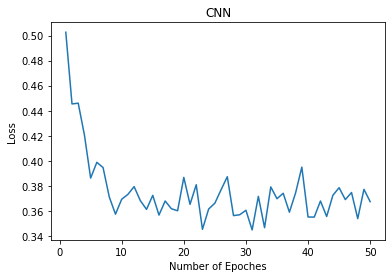

In [11]:
# draw the graph of the loss


for i in range(n_epochs):
    iteration_list.append(i+1)

plt.plot(iteration_list, loss_list)
plt.xlabel('Number of Epoches')
plt.ylabel('Loss')
plt.title('CNN')
plt.show()

In [12]:
# # draw the graph of the accuracy
# plt.plot(iteration_list, accuracy_list, color='b')
# plt.xlabel('Number of Epoches')
# plt.ylabel('Accuracy')
# plt.title('CNN')
# #plt.savefig('LSTM_accuracy2.png')
# plt.show()

In [13]:
# Compute the confusion matrix and F1_score, Acc, Recall_rate, and Precision

import numpy as np

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(network, device, test_loader)
print(actuals)
print(np.shape(actuals))
k = confusion_matrix(actuals, predictions)
print('Confusion matrix:')
print(k)
print('F1 score: %f' % f1_score(actuals, predictions, average='macro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
print('Recall score: %f' % recall_score(actuals, predictions, average='micro'))
print('Precision score: %f' % precision_score(actuals, predictions, average='macro'))

[9, 2, 1, 7, 7, 6, 1, 1, 0, 5, 9, 5, 4, 8, 2, 2, 8, 0, 7, 5, 0, 2, 0, 7, 1, 2, 6, 4, 9, 3, 8, 2, 9, 8, 7, 7, 0, 5, 3, 0, 2, 2, 9, 5, 8, 3, 4, 1, 4, 3, 6, 0, 4, 8, 6, 4, 2, 4, 1, 9, 0, 2, 7, 0, 5, 7, 8, 0, 6, 5, 6, 6, 1, 9, 6, 5, 2, 6, 0, 5, 9, 0, 2, 3, 4, 1, 6, 6, 0, 8, 8, 4, 9, 9, 1, 5, 6, 9, 9, 1, 9, 9, 2, 1, 4, 6, 9, 0, 0, 6, 8, 2, 7, 6, 1, 6, 8, 0, 8, 2, 4, 1, 9, 4, 1, 7, 2, 5, 7, 3, 0, 6, 8, 2, 8, 8, 9, 2, 1, 0, 6, 9, 0, 3, 3, 5, 3, 8, 5, 5, 8, 8, 4, 0, 3, 2, 1, 7, 7, 1, 9, 2, 1, 1, 2, 9, 5, 3, 7, 6, 2, 0, 8, 9, 9, 2, 1, 2, 2, 4, 8, 7, 4, 6, 0, 4, 0, 6, 6, 4, 1, 7, 8, 6, 3, 8, 7, 2, 9, 7, 1, 2, 1, 2, 9, 1, 7, 5, 8, 4, 4, 7, 1, 4, 7, 9, 7, 9, 4, 4, 8, 9, 5, 6, 7, 4, 5, 3, 8, 3, 2, 1, 0, 3, 1, 3, 8, 3, 2, 4, 9, 3, 2, 4, 1, 8, 5, 1, 2, 9, 9, 7, 2, 3, 4, 6, 6, 9, 5, 0, 8, 4, 4, 7, 2, 4, 8, 0, 3, 8, 2, 6, 6, 7, 0, 1, 1, 6, 6, 3, 5, 6, 6, 8, 2, 4, 4, 4, 6, 4, 6, 9, 9, 3, 9, 9, 8, 7, 2, 7, 6, 9, 5, 7, 3, 6, 5, 9, 8, 4, 5, 5, 3, 3, 2, 6, 4, 8, 9, 2, 1, 8, 8, 0, 6, 3, 6, 4, 2, 0, 8, 6, 7, 

In [14]:
np.shape(actuals)

(10000,)

In [15]:
np.shape(output_prob[(n_epochs-1)*10:n_epochs*10][:][:])

(10, 1000, 10)

In [16]:
out_prob = np.reshape(output_prob[(n_epochs-1)*10:n_epochs*10][:][:],(-1, 10))

In [17]:
np.shape(out_prob)

(10000, 10)

In [18]:
import pandas as pd
out_prob = pd.DataFrame(out_prob)

In [19]:
actuals = pd.DataFrame(actuals)
actuals.to_csv('actual_label.csv', sep = ',')

In [20]:
np.exp(out_prob).to_csv('output_prob.csv', sep = ',')

In [21]:
print(classification_report(actuals, predictions))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1000
           1       1.00      0.93      0.96      1000
           2       0.83      0.68      0.74      1000
           3       0.87      0.88      0.87      1000
           4       0.68      0.90      0.77      1000
           5       0.96      0.97      0.97      1000
           6       0.65      0.57      0.60      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.96      0.97      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



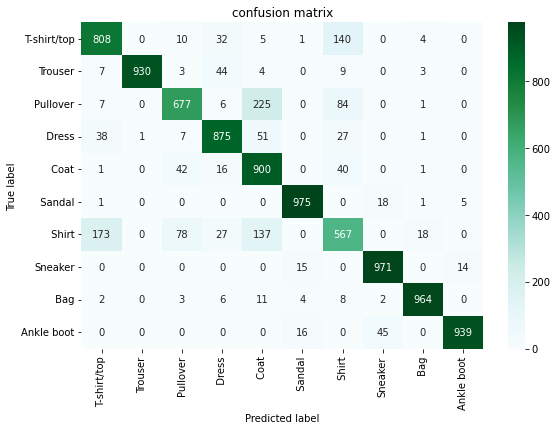

In [22]:
#draw the heatmap of confusion matrix

import seaborn as sns
# Display the confusion matrix as a heatmap
class_names = ['T-shirt/top', 'Trouser', 'Pullover', '  Dress', ' Coat', '  Sandal', ' Shirt', 'Sneaker', ' Bag', 'Ankle boot']
df_cm = pd.DataFrame(k, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("confusion matrix")
plt.show()

The area under the ROC curve: 0.951706


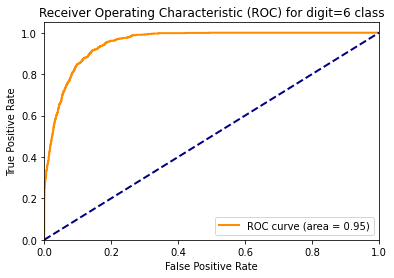

In [23]:
#check the ROC and AUROC of a class


which_class = 6

def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            #setting the target tensor size to same as prediction tensor size
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]


actuals, class_probabilities = test_class_probabilities(network, device, test_loader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr) #Compute the area under the ROC curve.
print('The area under the ROC curve: %f' % roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()
#plt.savefig("ROC.png")